# Project 7: A menu's carbon footprint



Authors: NGUYEN Hoai-Nam & SAYETTAT Anatole

Date: 07/01/2024

## 1. Introduction

In a 2022 study conducted by 'Les Echos,' it was revealed that the sandwich stands out as the predominant choice among restauration products in France, boasting an impressive 2.61 billion units sold in 2021. In light of this data and with our project's objective to assess the carbon footprint of various menu items, we found it pertinent to delve into the environmental impact of some of the most widely consumed sandwiches in France. For this purpose, we have selected two of the most popular bakeries in the country, Paul and Brioche Dorée, based on their significant sales figures and the accessibility of their menus. Our intention is to estimate the carbon footprint associated with each sandwich listed on their respective websites.

To this end, we will scrap the web menus of the two aforementioned bakeries in order to gather their contents. Both restaurants provide information about their sandwiches, including ingredients and various nutritional information. While the nutritional group weights are available, the weights of individual ingredients are absent. To fill this gap, we turn to the CIQUAL Table, a database from the Food Observatory of the French National Agency for Food, providing percentage nutritional composition for various ingredients. Key nutritional elements considered are limited to Water, Glucide, Proteins, Lipids, Fiber, and Sodium, as other nutrients contribute minimally to overall nutient composition.

The challenge involves solving a system of equations, with ingredient weights as variables. Represented as $ A \cdot B = C $, where $ A $ signifies the matrix of nutritional percentage per ingredient, $ B $ denotes the matrix of ingredient weights, and $ C $ embodies the matrix of nutritional weights per sandwich. However, direct solution proves impractical due to a constraint mismatch between the number of equations and variables. Therefore, we opt for estimating ingredient weights by solving a minimization problem, constrained by the requirement that all ingredient weights remain strictly positive, expressed as $ \min(A \cdot B - C) $ subject to $ B > 0 $.

Once estimated ingredient weights are obtained, we proceed to calculate the carbon footprint for each sandwich. Using the AGRIBALYSE database, a collaborative effort between the French Ministry of Agriculture and the "Agence de la Transition Ecologique", we obtain environmental footprints for various food products. Carbon footprint measurements are in kilograms (kg), while sandwich weights are in grams. To facilitate standardized comparisons among sandwiches of the same weight scale, we scale all ingredient weights to 1 kg.

It's crucial to highlight that our approach involves virtual sandwich composition based on information sourced from restaurant websites, rather than physical assembly.

Furthermore, we delve into a deeper analysis by implementing a Mermaid flow chart to identify the sandwich composition that minimizes carbon dioxide emissions. Additionally, we explore the Skyline approach to identify sandwiches that minimize their carbon footprint (measured in kg) while maximizing their energy content (measured in kcal).

Moreover, our investigation extends to a comprehensive analysis, incorporating a Mermaid flow chart to pinpoint the sandwich compositions that yield minimal carbon dioxide emissions. Furthermore, we explore the Skyline approach to identify the sandwiches that have a minimal carbon footprint (measured in kg) while having a maximal energy content (measured in kcal). Furthermore, we construct a clustering dendrogram visualization to discern patterns in sandwich compositions, providing valuable insights into groupings based on nutritional and environmental similarities. Additionally, a Principal Component Analysis (PCA) is conducted to unveil underlying patterns and relationships within the dataset.


In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import random

random.seed(2024)

## 2. Menu's scrapping

As previously mentioned, we will do some web scrapping to build an initial data frame with our sandwich menus; we are interested in the sandwich names, their ingredients and nutritional contents. We will use the Python package 'bs4' and inspect the respective source code of the web menus of Paul and Brioche Dorée in order to extract the needed information.

### 2.1. Paul

In [2]:

# Send an HTTP GET request to the URL containing the sandwich links
menu_url = "https://www.paul.fr/dejeuner/sandwichs"
menu_response = requests.get(menu_url)
menu_soup = BeautifulSoup(menu_response.content, 'html.parser')

# Find all the sandwich links and names
sandwich_all = menu_soup.find_all("a", class_="block no-underline font-book text-12 md-text-14")
sandwich_links = [sandwich['href'] for sandwich in sandwich_all]
sandwich_names = [sandwich.text.strip() for sandwich in sandwich_all]

# Create an empty DataFrame to store the combined data
paul_df = pd.DataFrame()


# Loop through the list of HTML links and sandwich names
for link, name in zip(sandwich_links, sandwich_names):
    
    # Define the URL 
    url = link
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    content_element_desc = soup.find('div', class_='value font-book leading-26')
    if content_element_desc is None:
        # Handle cases where 'nutri_content' is missing, for example, by adding a placeholder value
        description_df = pd.DataFrame({"Description": ["Data not available"]})
    else:
        # Continue processing as before
        scraped_content_desc = content_element_desc.get_text()

        description_df = pd.DataFrame({"Description": [scraped_content_desc]})
            
    # Check if there is a 'nutri_content' element on the page
    content_element = soup.find('div', class_='nutri_content')
    
    if content_element is None:
        # Handle cases where 'nutri_content' is missing, for example, by adding a placeholder value
        ingredients_df = pd.DataFrame({"Ingredients": ["Data not available"]})
    else:
        # Continue processing as before
        scraped_content = content_element.find('span').get_text()

        ingredients_df = pd.DataFrame({"Ingredients": [scraped_content]})

        # Check if there is a 'table' element within the 'nutri_content'
        table_element = content_element.find('table')

        if table_element is not None:
            # Create an empty DataFrame
            data = []

            # Iterate through the rows of the table to extract data
            for row in table_element.find_all('tr'):
                columns = row.find_all('td')
                if columns:
                    row_data = [col.get_text(strip=True) for col in columns]
                    data.append(row_data)

            # Create a DataFrame
            df = pd.DataFrame(data, columns=['Nutrient', '100.00 g', 'Par portion'])

            # Transpose dataframe 
            df = df[df.columns.difference(["100.00 g"])].T

            df.columns = df.iloc[0]

            # Drop the first row
            df = df[1:]

            df.reset_index(drop=True, inplace=True)

            combined_df = pd.concat([description_df, ingredients_df, df], axis=1)
        else:
            # Handle cases where the table is missing, for example, by adding a placeholder value
            combined_df = pd.concat([description_df, ingredients_df, pd.DataFrame({"Nutrient": ["Data not available"], "Par portion": ["Data not available"]})], axis=1)

        # Add a new column "Name" with the sandwich name
        combined_df['Name'] = name

        # Concatenate the current combined_df with the paul.df
        paul_df = pd.concat([paul_df, combined_df], axis=0)
    
# Reset the index of the final DataFrame
paul_df.reset_index(drop=True, inplace=True)

# Reorder the column
order = ['Name', 'Description', 'Ingredients', 'Valeurs énergétiques', "Matières grasses",
       'Dont Acides Gras Saturés', 'Glucides', 'Dont sucres',
       'Fibres alimentaires', 'Protéines', 'Sel']

paul_df = paul_df[order]

paul_df['Description'] = paul_df['Description'].str.lstrip('\n')
paul_df['Description'] = paul_df['Description'].str.replace('\n', '. ')

paul_df = paul_df.loc[~paul_df['Name'].isin(['Menu Sandwich', 'Menu Végétalien'])]
paul_df['Boulangerie'] = 'Paul'
paul_df

Name  \
0                    Le Sandwich Sublime   
1                 Le bun gourmet brioché   
2                     Le nordique avocat   
3                   Le sandwich dieppois   
4           Le sandwich sésame camembert   
5                 Le sandwich montagnard   
6           Le sandwich curcuma falafels   
7                     Le hot dog cheddar   
8               Le croissant oeuf mimosa   
9               Le croissant chèvre miel   
10           Le croissant bacon emmental   
11                      Le wrap dieppois   
12                        Le wrap saumon   
13                 Le wrap poulet grainé   
16                    Le croque monsieur   
17      Le sandwich chèvre, miel et noix   
18   Le sandwich chaud tomate mozzarella   
19      Le sandwich chaud jambon fromage   
20  Le sandwich chaud poulet ciboulettte   
21                  Le sandwich parisien   
22                  Le paulisson rosette   
23            Le sandwich poulet crudité   
24                   Le paulisson poulet   
25                  Le paulisson  chèvre   
26             Le sandwich grainé poulet   
27                Le paulisson camembert   
28                   Le paulisson jambon   
29         Le sandwich tomate mozzarella   
30                Le sandwich atlantique   
31   Le sandwich viennois mixte crudités   
32                 Le sandwich savoureux   
33                     Le sandwich mixte   

                                          Description  \
0   Un sandwich sucré-salé gourmand. Testez ce san...   
1   Ce sandwich se compose d'une brioche, de rôti ...   
2   Ce sandwich se compose de pain nordique, de sa...   
3   Le dieppois, c’est un sandwich au thon version...   
4   Pas besoin de porter le béret pour déguster ce...   
5   Le montagnard est un sandwich généreux qui ras...   
6   Un sandwich oriental savoureux. Ce sandwich jo...   
7   Un hot dog maxi gourmand. Vous connaissez le p...   
8   Naturel et frais : le croissant bon pour la sa...   
9   Le croissant aux produits du terroir. Les boul...   
10  Un croissant plus que gourmand. Le croissant, ...   
11  Un wrap à la fraîcheur marine. Le wrap, on aim...   
12  Un wrap chic et frais. Le wrap saumon PAUL se ...   
13  Un wrap attirant par ses couleurs et ses saveu...   
16  Un monsieur qu’on adore croquer !. Est-ce un s...   
17  Un sandwich qui explose de saveurs. Entre deux...   
18                                 Data not available   
19                                 Data not available   
20                                 Data not available   
21  Le sandwich jambon ou sandwich parisien est un...   
22  Un petit pain aux saveurs contrastées. Ce peti...   
23  Le sandwich poulet crudités, c’est un sandwich...   
24  Un petit pain extra moelleux. Le paulisson pou...   
25  Relevé et moelleux : contrastes réussis du pau...   
26  Le sandwich poulet grainé, c’est un pain très ...   
27  Douceur et moelleux pour fans de fromage. Le g...   
28  Le petit pain incontournable. Il est tout simp...   
29  C’est le sud et tous ses parfums généreux que ...   
30  Ce sandwich associe délicatement le saumon, le...   
31  Un pain moelleux comme un nuage, c’est déjà le...   
32  Être croustillant et fondant à la fois, c’est ...   
33  Le mixte, c’est le sandwich traditionnel par e...   

                                          Ingredients Valeurs énergétiques  \
0                                                              678.84 kcal   
1                                                              538.73 kcal   
2                                                              565.44 kcal   
3   Le Dieppois est fait à partir d'une baguette c...          552.31 kcal   
4   Un sandwich élaboré à partir d'une baguette au...          668.58 kcal   
5   Un sandwich élaboré à partir d'une baguette au...          546.04 kcal   
6   Ce sandwich est composé de pain au curcuma et ...          501.98 kcal   
7   \nLe hot dog à la française fait son entrée ch...          843.56 kcal   

We notice that the sandwiches "Le sandwich chaud tomate mozzarella", "Le sandwich chaud jambon fromage" and "Le sandwich chaud poulet ciboulettte" have no information listed regarding their contents on the Paul website. We will remove these sandwiches. Furthermore, throughout this project we have noticed that the Paul web menu is subject to changes as items are regularly added or removed from the menu. We have decided to only keep the sandwiches that were on the menu when we conducted the carbon footprint analysis; this is why we remove "Le hot dog cheddar" and "Le sandwich chèvre, miel et noix". 

(Note: In annex to this notebook, we will also attach a file which contains the exact Paul menu we used, just in case the menu is subjects to additional changes in the future) 

In [3]:
paul_df = paul_df[~(paul_df.Name.isin(['Le hot dog cheddar', 'Le sandwich chèvre, miel et noix',
                            'Le sandwich chaud tomate mozzarella', 'Le sandwich chaud jambon fromage',
                            'Le sandwich chaud poulet ciboulettte']))].reset_index(drop=True)

We also notice from our original web scrapping that the sandwiches have their ingredients listed in the form of crafted sentences. This is of no use to us and is cumbersome with regards to evaluating the weight of each ingredient in each sandwich. We wish to have, for each observation is our data frame, an ingredient column where figures a list with every ingredient is the sandwich. To do so, we will transform each cell in the "Ingredients" column so that we have only the ingredients, seperated by a comma; from this we will convert each cell in list format.

For this end, we have decided to apply a few custom functions to the "Ingredients" column:


- remove_stopwords: this function removes all French stop words that may be included in a cell. Indeed, stop words do not give us any information about the sandwich ingredients. 
    (The stop words in French are: 'au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aurez', 'auront', 'aurais', 'aurait', 'aurions', 'auriez', 'auraient', 'avais', 'avait', 'avions', 'aviez', 'avaient', 'eut', 'eûmes', 'eûtes', 'eurent', 'aie', 'aies', 'ait', 'ayons', 'ayez', 'aient', 'eusse', 'eusses', 'eût', 'eussions', 'eussiez', 'eussent') 


- remove_before_baguette_or_pain: this function removes all information contained in a cell that figures before the word "pain" or "baguette". Indeed, we notice that for every cell in the "Ingredients" column, the bread is always the first ingredient listed so everything that comes before does not give us any information about the sandwich ingredients.


- replace_compose: this function replaces the words "composé d'un" and their variants like "composée d'une", "composée d'un", etc. with a comma. Indeed, we notice that every cell in the "Ingredients" column has a structure that follows the bread ingredient by "composé d'un" (or one of its grammatical variants), and then an enumeration of the ingredients. With this function, we wish to simply replace this by a comma so that each cell is closer to the list format we are after. 


- replace_last_et: this function replaces that final "et" with a comma. Indeed, after each ingredient is enumerated and separated by commas, the final ingredient is preceded by an "et" ("and") as it is a sentence. Replacing this final "et" by a comma gives us the format that we are after.


After applying these functions to the variable "Ingredients", we remove will remove any and all special characters and convert each cell in our desired list format. 

In [4]:
import re
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
#print(stopwords.words('french'))

def remove_stopwords(description):
    stop_words = set(stopwords.words('french'))
    words = word_tokenize(description)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def remove_before_baguette_or_pain(description):
    cleaned_description = re.sub(r'.*(baguette|pain)', r'\1', description, flags=re.IGNORECASE)
    return cleaned_description.strip()

def replace_compose(description):
    cleaned_description = re.sub(r'compos[éeé]* d[\'eune]*', ', ', description, flags=re.IGNORECASE)
    return cleaned_description.strip()

def replace_last_et(description):
    reversed_description = description[::-1].replace('te', ', ', 1)[::-1]
    return reversed_description



paul_df['Ingredients'] = paul_df['Ingredients'].apply(remove_before_baguette_or_pain)
paul_df['Ingredients'] = paul_df['Ingredients'].apply(replace_compose)
paul_df['Ingredients'] = paul_df['Ingredients'].apply(replace_last_et)
paul_df['Ingredients'] = paul_df['Ingredients'].apply(remove_stopwords)

paul_df['Ingredients'] = paul_df['Ingredients'].str.replace('[.\']', '')
paul_df['Ingredients'] = paul_df['Ingredients'].apply(lambda x: [i.strip() for i in x.split(',')] if x else x)
paul_df

[nltk_data] Downloading package punkt to /Users/hoainam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hoainam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Name  \
0                   Le Sandwich Sublime   
1                Le bun gourmet brioché   
2                    Le nordique avocat   
3                  Le sandwich dieppois   
4          Le sandwich sésame camembert   
5                Le sandwich montagnard   
6          Le sandwich curcuma falafels   
7              Le croissant oeuf mimosa   
8              Le croissant chèvre miel   
9           Le croissant bacon emmental   
10                     Le wrap dieppois   
11                       Le wrap saumon   
12                Le wrap poulet grainé   
13                   Le croque monsieur   
14                 Le sandwich parisien   
15                 Le paulisson rosette   
16           Le sandwich poulet crudité   
17                  Le paulisson poulet   
18                 Le paulisson  chèvre   
19            Le sandwich grainé poulet   
20               Le paulisson camembert   
21                  Le paulisson jambon   
22        Le sandwich tomate mozzarella   
23               Le sandwich atlantique   
24  Le sandwich viennois mixte crudités   
25                Le sandwich savoureux   
26                    Le sandwich mixte   

                                          Description  \
0   Un sandwich sucré-salé gourmand. Testez ce san...   
1   Ce sandwich se compose d'une brioche, de rôti ...   
2   Ce sandwich se compose de pain nordique, de sa...   
3   Le dieppois, c’est un sandwich au thon version...   
4   Pas besoin de porter le béret pour déguster ce...   
5   Le montagnard est un sandwich généreux qui ras...   
6   Un sandwich oriental savoureux. Ce sandwich jo...   
7   Naturel et frais : le croissant bon pour la sa...   
8   Le croissant aux produits du terroir. Les boul...   
9   Un croissant plus que gourmand. Le croissant, ...   
10  Un wrap à la fraîcheur marine. Le wrap, on aim...   
11  Un wrap chic et frais. Le wrap saumon PAUL se ...   
12  Un wrap attirant par ses couleurs et ses saveu...   
13  Un monsieur qu’on adore croquer !. Est-ce un s...   
14  Le sandwich jambon ou sandwich parisien est un...   
15  Un petit pain aux saveurs contrastées. Ce peti...   
16  Le sandwich poulet crudités, c’est un sandwich...   
17  Un petit pain extra moelleux. Le paulisson pou...   
18  Relevé et moelleux : contrastes réussis du pau...   
19  Le sandwich poulet grainé, c’est un pain très ...   
20  Douceur et moelleux pour fans de fromage. Le g...   
21  Le petit pain incontournable. Il est tout simp...   
22  C’est le sud et tous ses parfums généreux que ...   
23  Ce sandwich associe délicatement le saumon, le...   
24  Un pain moelleux comme un nuage, c’est déjà le...   
25  Être croustillant et fondant à la fois, c’est ...   
26  Le mixte, c’est le sandwich traditionnel par e...   

                                          Ingredients Valeurs énergétiques  \
0                                                              678.84 kcal   
1                                                              538.73 kcal   
2                                                              565.44 kcal   
3   [baguette, mayonnaise allégée, thon, feuilles ...          552.31 kcal   
4   [baguette graines sésame, beurre, camembert, ,...          668.58 kcal   
5   [baguette pavot, tomates, coppa, tartinade oli...          546.04 kcal   
6   [pain curcuma sésame noir, falafels, houmous b...          501.98 kcal   
7                                                              413.76 kcal   
8                                                              426.94 kcal   
9                                                              417.28 kcal   
10                                                             416.21 kcal   
11                                                             425.84 kcal   
12                                                             462.58 kcal   
13                                                             481.89 kcal   
14                         [baguette, jambon, beurre]          

Finally, in the Paul web menu, some sandwiches are not given a value for the "Ingredients" variable. However, we can find the ingredients of these sandwiches in the "Description" variable. Unfortunately, the sandwich descriptions are well crafted sentences that are far more detailed and embellished than before. For the 16 sandwiches concerned, we will manually input there ingredient list based on the descriptions. As meticulous as this sounds, given the limited amount of observations concerned, we judge this method the fastest and the most reliable. 

In [5]:
ingredients_1 = [
    "pain multigraine", "jambon cru", "poire", "parmesan", "salade Roquette", "tartinade à la truffe"
]

ingredients_2 = [
    "brioche", "rôti de bœuf origine France", "mousse de foie gras de canard", "confit d'oignon", "salade", "pomme", "oignon rouge"
]

ingredients_3 = [
    "pain nordique", "saumon fumé", "avocat", "carotte", "radis", "tartinade citron ciboulette"
]

ingredients_4 = [
    "croissant", "œufs mimosa", "pousses d'épinards"
]

ingredients_5 = [
    "croissant pur beurre", "beurre frais", "fromage de chèvre", "tomates cerises", "salade roquette", "noix", "miel d’acacia"
]

ingredients_6 = [
    "croissant pur beurre", "bacon", "emmental"
]


ingredients_7 = [
    "galette de blé", "thon citronné", "salade", "tomate", "concombre"
]

ingredients_8 = [
    "galette de blé", "saumon fumé", "salade", "tomate", "tartinade citron aneth"
]

ingredients_9 = [
    "galette de blé", "poulet grainé", "salade verte", "tomate", "mayonnaise au curcuma et à l’échalote"
]

ingredients_10 = [
    "pain de mie", "jambon", "fromage", "crème"
]


ingredients_11 = [
    "petit pain au lait", "rosette", "cornichon"
]


ingredients_12 = [
    "baguette", "poulet", "mayonnaise allégée", "salade", "tomate"
]


ingredients_13 = [
    "petit pain au lait", "poulet", "mayonnaise allégée", "salade", "tomate"
]


ingredients_14 = [
    "petit pain au lait", "fromage de chèvre", "tartinade nature", "pesto", "huile", "salade", "tomate"
]

ingredients_15 = [
    "petit pain au lait", "camembert", "salade", "moutarde"
]

ingredients_16 = [
    "petit pain au lait", "salade verte", "tartinade nature", "jambon"
]


combined_ingredients = [
    ingredients_1, ingredients_2, ingredients_3, ingredients_4,
    ingredients_5, ingredients_6, ingredients_7, ingredients_8,
    ingredients_9, ingredients_10, ingredients_11, ingredients_12,
    ingredients_13, ingredients_14, ingredients_15, ingredients_16
]

ingredient_index = 0

for index, row in paul_df.iterrows():
    if row['Ingredients'] == '':
        paul_df.at[index, 'Ingredients'] = combined_ingredients[ingredient_index]
        ingredient_index += 1
paul_df['Ingredients'] = paul_df['Ingredients'].apply(lambda x: [i for i in x if i])

In [6]:
#final corrections
#putting everything in singular and removing redundancies
paul_df.loc[3, 'Ingredients'].clear()
corrected =  ['baguette', 'mayonnaise allégée', 'thon', 'salade', 'tomate']
paul_df.loc[3, 'Ingredients'].extend(corrected)

paul_df.loc[4, 'Ingredients'].clear()
corrected = ['baguette graines sésame', 'beurre', 'camembert', 'salade']
paul_df.loc[4, 'Ingredients'].extend(corrected)

paul_df.loc[19, 'Ingredients'].clear()
corrected = ['pain multigraine', 'poulet', 'mayonnaise allégée', 'moutarde', 'salade', 'tomates']
paul_df.loc[19, 'Ingredients'].extend(corrected)

paul_df.loc[22, 'Ingredients'].clear()
corrected = ['pain polka flamand 2 olives', 'pesto huile', 'tomate', 'mozzarella', 'salade']
paul_df.loc[22, 'Ingredients'].extend(corrected)

paul_df.loc[23, 'Ingredients'].clear()
corrected = ['baguette graines sésame', 'tartinade citron', 'saumon fumé', 'salade', 'tomate']
paul_df.loc[23, 'Ingredients'].extend(corrected)

paul_df.loc[24, 'Ingredients'].clear()
corrected = ['pain viennois', 'jambon blanc qualité supérieur', 'emmental', 'salade', 'tartinade nature']
paul_df.loc[24, 'Ingredients'].extend(corrected)

paul_df.loc[25, 'Ingredients'].clear() 
corrected = ['baguette', 'beurre', 'rosette', 'cornichon']
paul_df.loc[25, 'Ingredients'].extend(corrected)

paul_df.loc[26, 'Ingredients'].clear()
corrected = ['baguette', 'beurre', 'jambon qualité supérieure dégraissé', 'emmental']
paul_df.loc[26, 'Ingredients'].extend(corrected)

In [7]:
paul_df

Name  \
0                   Le Sandwich Sublime   
1                Le bun gourmet brioché   
2                    Le nordique avocat   
3                  Le sandwich dieppois   
4          Le sandwich sésame camembert   
5                Le sandwich montagnard   
6          Le sandwich curcuma falafels   
7              Le croissant oeuf mimosa   
8              Le croissant chèvre miel   
9           Le croissant bacon emmental   
10                     Le wrap dieppois   
11                       Le wrap saumon   
12                Le wrap poulet grainé   
13                   Le croque monsieur   
14                 Le sandwich parisien   
15                 Le paulisson rosette   
16           Le sandwich poulet crudité   
17                  Le paulisson poulet   
18                 Le paulisson  chèvre   
19            Le sandwich grainé poulet   
20               Le paulisson camembert   
21                  Le paulisson jambon   
22        Le sandwich tomate mozzarella   
23               Le sandwich atlantique   
24  Le sandwich viennois mixte crudités   
25                Le sandwich savoureux   
26                    Le sandwich mixte   

                                          Description  \
0   Un sandwich sucré-salé gourmand. Testez ce san...   
1   Ce sandwich se compose d'une brioche, de rôti ...   
2   Ce sandwich se compose de pain nordique, de sa...   
3   Le dieppois, c’est un sandwich au thon version...   
4   Pas besoin de porter le béret pour déguster ce...   
5   Le montagnard est un sandwich généreux qui ras...   
6   Un sandwich oriental savoureux. Ce sandwich jo...   
7   Naturel et frais : le croissant bon pour la sa...   
8   Le croissant aux produits du terroir. Les boul...   
9   Un croissant plus que gourmand. Le croissant, ...   
10  Un wrap à la fraîcheur marine. Le wrap, on aim...   
11  Un wrap chic et frais. Le wrap saumon PAUL se ...   
12  Un wrap attirant par ses couleurs et ses saveu...   
13  Un monsieur qu’on adore croquer !. Est-ce un s...   
14  Le sandwich jambon ou sandwich parisien est un...   
15  Un petit pain aux saveurs contrastées. Ce peti...   
16  Le sandwich poulet crudités, c’est un sandwich...   
17  Un petit pain extra moelleux. Le paulisson pou...   
18  Relevé et moelleux : contrastes réussis du pau...   
19  Le sandwich poulet grainé, c’est un pain très ...   
20  Douceur et moelleux pour fans de fromage. Le g...   
21  Le petit pain incontournable. Il est tout simp...   
22  C’est le sud et tous ses parfums généreux que ...   
23  Ce sandwich associe délicatement le saumon, le...   
24  Un pain moelleux comme un nuage, c’est déjà le...   
25  Être croustillant et fondant à la fois, c’est ...   
26  Le mixte, c’est le sandwich traditionnel par e...   

                                          Ingredients Valeurs énergétiques  \
0   [pain multigraine, jambon cru, poire, parmesan...          678.84 kcal   
1   [brioche, rôti de bœuf origine France, mousse ...          538.73 kcal   
2   [pain nordique, saumon fumé, avocat, carotte, ...          565.44 kcal   
3   [baguette, mayonnaise allégée, thon, salade, t...          552.31 kcal   
4   [baguette graines sésame, beurre, camembert, s...          668.58 kcal   
5   [baguette pavot, tomates, coppa, tartinade oli...          546.04 kcal   
6   [pain curcuma sésame noir, falafels, houmous b...          501.98 kcal   
7        [croissant, œufs mimosa, pousses d'épinards]          413.76 kcal   
8   [croissant pur beurre, beurre frais, fromage d...          426.94 kcal   
9             [croissant pur beurre, bacon, emmental]          417.28 kcal   
10  [galette de blé, thon citronné, salade, tomate...          416.21 kcal   
11  [galette de blé, saumon fumé, salade, tomate, ...          425.84 kcal   
12  [galette de blé, poulet grainé, salade verte, ...          462.58 kcal   
13              [pain de mie, jambon, fromage, crème]          481.89 kcal   
14                         [baguette, jambon, beurre]          

To adress the fact that Paul's menu is subject to changes, we save this data frame in a "csv" format.

In [8]:
paul_df.to_csv("Paul.csv", index=False)

### 2.2. Brioche Dorée 

We proceed the same way to construct a data frame of Brioche Dorée's sandwich menu. This web menu is more consistent and well-bahaved compared to the Paul menu so it does not require much work past the initial web scrapping; we just convert the "Ingredients" column in list format as well as convert the sodium contents from milligrams (mg) to grams (g) while removing the unit accronym.  

In [9]:
# Send an HTTP GET request to the URL containing the sandwich links
menu_url = "https://www.briochedoree.fr/carte/categorie/SANDWICHS/sandwichs"
menu_response = requests.get(menu_url)
menu_soup = BeautifulSoup(menu_response.content, 'html')

# Find all the sandwich names, links and descriptions
sandwich_names = menu_soup.find_all("div", class_ = "Product-name cbs-Product-name")
sandwich_desc = menu_soup.find_all("div", class_ = "Product-desc js-Product-desc")
sandwich_links = menu_soup.find_all("a", class_ = "Product-link js-product-link")

# Create an empty DataFrame to store the combined data
brido_df = pd.DataFrame()

# Loop through the list of HTML links and sandwich names
for link, description, name in zip(sandwich_links, sandwich_desc, sandwich_names):
    
    href = link['href']
    full_url = "https://www.briochedoree.fr" + href
    
    # Define the URL
    url = full_url
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Description dataframe gives the ingredients in each sandwich
    description_df = []
    des = description.text
    description_df.append(des)

    description_df = pd.DataFrame(description_df, columns=["Ingredients"])
    
    # Nutrition dataframe gives the nutrtional weights in each sandwich
    content_element = soup.find('table', class_="ProductPage-nutrientsTable")

    table_data = []
    rows = content_element.find_all('tr')

    for row in rows:
        cells = row.find_all('td')
        if len(cells) == 2:
            nutrient = cells[0].text.strip()
            value = cells[1].text.strip()
            table_data.append((nutrient, value))

    # Create a DataFrame from the table data
    df_nutrition = pd.DataFrame(table_data, columns=["Nutrient", "Value"])

    df_nutrition = df_nutrition.T

    df_nutrition.columns = df_nutrition.iloc[0]

    # Drop the first row
    df_nutrition = df_nutrition[1:]

    df_nutrition.reset_index(drop=True, inplace=True)

    # Name dataframe gives the name of sandwich
    name_df = []
    names = name.text
    name_df.append(names)
    
    name_df = pd.DataFrame(name_df, columns=["Name"])
    
    # Combined dataframe
    combined_df = pd.concat([name_df, description_df, df_nutrition], axis=1)

    # Concatenate the current combined_df with the brido_df
    brido_df = pd.concat([brido_df, combined_df], axis=0)
    
# Reset the index of the brido_df DataFrame
brido_df.reset_index(drop=True, inplace=True)

brido_df['Boulangerie'] = 'Brioche Dorée'

brido_df['Ingredients'] = brido_df['Ingredients'].apply(lambda x: [i.strip() for i in x.split(',')] if x else x)

brido_df['sodium'] = brido_df['sodium'].str.replace('mg', '').apply(lambda x: pd.to_numeric(x, errors='coerce'))
brido_df['sodium'] = brido_df['sodium']/1000

In [10]:
brido_df

Name  \
0            TOASTÉ JAMBON RACLETTE   
1   TOASTÉ RACLETTE SAUCISSE FUMÉE    
2               TOASTÉ POULET CURRY   
3             TOASTÉ GRILLED CHEESE   
4             CUISINÉ POULET CAESAR   
5     CUISINÉ SAUMON façon TERIYAKI   
6                         CHAMPÊTRE   
7      CUISINÉ BUTTERNUT ET MARRONS   
8       AUTHENTIQUE JAMBON EMMENTAL   
9         AUTHENTIQUE THON CRUDITÉS   
10      AUTHENTIQUE POULET CRUDITÉS   
11                        MINI THON   
12             MINI JAMBON EMMENTAL   

                                          Ingredients    energie protéines  \
0   [jambon, fromage à raclette, pain ciabatta, be...  606.0kcal     28.9g   
1   [pain ciabatta, saucisse fumée de porc*, racle...  603.0kcal     22.6g   
2   [pain ciabatta, poulet rôti* mariné à la crème...  598.0kcal     19.9g   
3   [pain ciabatta, tome, galettes de pomme de ter...  724.0kcal     19.5g   
4   [pain au lin, poulet rôti*, sauce parmesan, ca...  689.0kcal     23.0g   
5   [pain au lin, saumon fumé, mayonnaise façon Te...  611.0kcal     18.8g   
6   [pain au lin, allumettes de jambon sec, cantal...  603.0kcal     18.4g   
7   [pain au lin, mélange épeautre butternut et oi...  565.0kcal     14.4g   
8   [pain signature, jambon supérieur*, emmental, ...  625.0kcal     31.7g   
9   [pain signature, thon, œuf dur plein air, toma...  553.0kcal     23.5g   
10  [pain signature, poulet rôti*, œuf dur plein a...  534.0kcal     25.0g   
11  [pain bretzel, thon à la ciboulette et zeste d...  261.0kcal     11.0g   
12  [pain bretzel, jambon*, emmental, beurre léger...  308.0kcal     13.4g   

   glucides dont sucres lipides dont saturés fibres  sodium    Boulangerie  
0     67.0g       1.38g   23.9g        15.0g  3.78g  1.1140  Brioche Dorée  
1     76.4g        5.0g   22.0g        17.0g  4.84g  1.4490  Brioche Dorée  
2     75.9g       4.72g   22.6g        10.8g  5.43g  1.3960  Brioche Dorée  
3     78.3g       3.12g   35.8g        10.0g  5.15g  1.1790  Brioche Dorée  
4     71.3g       4.14g   33.3g        6.29g  6.12g  1.2400  Brioche Dorée  
5     26.3g        0.5g   29.0g        36.9g   2.2g  0.2842  Brioche Dorée  
6     62.9g       2.74g   29.8g        6.71g  4.85g  1.1220  Brioche Dorée  
7     29.8g        9.7g   24.5g          NaN   1.9g  0.2210  Brioche Dorée  
8     73.2g       5.96g   22.0g        11.8g  3.92g  0.1450  Brioche Dorée  
9     74.8g       8.16g   16.7g        2.11g  4.71g  0.3760  Brioche Dorée  
10    74.7g       8.04g   13.8g        1.88g  5.03g  0.2920  Brioche Dorée  
11    34.1g       3.62g   8.55g        9.21g  2.19g  0.5200  Brioche Dorée  
12    35.3g       3.18g   12.2g        8.28g  1.97g  0.5890  Brioche Dorée

In [11]:
brido_df.to_csv("Brioche_Doree.csv", index=False)

### 2.3. Combined Menu 

Now that we have successfully constructed data frames containing the names, ingredients and nutritional contents of each sandwich, we wish to merge them together as to have one complete data frame with all the sandwiches we will use for our carbon footprint analysis. 

Before the merger takes place, we must first standardize the variable names and varaible formats. We also add a "Sandwich ID" variable so that each observation as a unique identifier. 

In [12]:
paul_df2 = paul_df.copy()
brido_df2 = brido_df.copy()

paul_column_name_changes = {'Valeurs énergétiques': 'Énergie', 'Dont Acides Gras Saturés': 'Dont saturés', 'Fibres alimentaires': 'Fibres'}
paul_df2 = paul_df2.rename(columns=paul_column_name_changes)
brido_column_name_changes = {'energie': 'Énergie', 'dont saturés': 'Dont saturés', 'dont sucres': 'Dont sucres', 'fibres': 'Fibres', 'protéines': 'Protéines', 'glucides': 'Glucides', 'lipides': 'Matières grasses', 'sodium': 'Sel'}
brido_df2 = brido_df2.rename(columns=brido_column_name_changes)

energy_column = ['Énergie']
weight_columns_paul = ['Matières grasses', 'Glucides', 'Fibres', 'Protéines', 'Sel']
paul_df2[energy_column] = paul_df2[energy_column].apply(lambda x: pd.to_numeric(x.str.replace(' kcal',''), errors='coerce'))
paul_df2[weight_columns_paul] = paul_df2[weight_columns_paul].apply(lambda x: pd.to_numeric(x.str.replace(' g', ''), errors='coerce'))

weight_columns_brido = ['Matières grasses', 'Glucides', 'Fibres', 'Protéines']
brido_df2[energy_column] = brido_df2[energy_column].apply(lambda x: pd.to_numeric(x.str.replace('kcal',''), errors='coerce'))
brido_df2[weight_columns_brido] = brido_df2[weight_columns_brido].apply(lambda x: pd.to_numeric(x.str.replace('g', ''), errors='coerce'))

In [13]:

combined_df = pd.concat([paul_df2, brido_df2], ignore_index=True)

combined_column_name_changes = {'Énergie': 'Énergie (kcal)', 'Matières grasses': 'Matières grasses (g)', 'Glucides': 'Glucides (g)', 'Fibres': 'Fibres (g)', 'Protéines': 'Protéines (g)', 'Sel': 'Sel (g)'}
combined_df = combined_df.rename(columns=combined_column_name_changes)

columns_to_drop = ['Description', 'Dont saturés', 'Dont sucres']
combined_df = combined_df.drop(columns=columns_to_drop)
combined_df.insert(0, 'Sandwich ID', [f"{i + 1:03d}" for i in range(len(combined_df))])


### 2.4 Nutritional Table

Before computing the weight of each ingredient per sandwich, so that we can effectively estimate the carbon footprint of every sandwich, we need to gather reliable nutritional information on each ingredient that figures in our combined table. 

For this, we will use the CIQUAL Table, a database from the Food Observatory of the French National Agency for Food, providing percentage nutritional composition for various ingredients. 

In [14]:
flat_ingredients = [item for sublist in combined_df['Ingredients'] for item in sublist]
unique_ingredients = set(flat_ingredients)
unique_ingredients_list = list(unique_ingredients)
print(unique_ingredients_list)
print(len(unique_ingredients_list))

['tartinade à la truffe', 'batavia', 'tomates cerises', 'salade roquette', 'mousse de foie gras de canard', 'sauce barbecue et poivre', 'tome', 'noix', 'tartinade nature', 'crème', 'parmesan', 'mélange de carottes chou blanc et céleri', 'courgettes', 'salade', 'tartinade olive noire', 'pain bretzel', "jeunes pousses d'épinards * Origine France", 'jambon blanc qualité supérieur', 'sauce parmesan', 'bacon', 'cornichon', 'galette de blé', 'huile d’olive', 'huile', 'pain viennois', 'jambon cru', 'petit pain au lait', 'jambon', 'cantal AOP', 'mélange épeautre butternut et oignons rouges', "jeunes pousses d'épinards", 'pain ciabatta', 'mayonnaise façon Teriyaki', 'baguette pavot', 'poulet rôti* mariné à la crème et curry', 'pousses dépinards', 'raclette', 'tomates', 'baguette graines sésame', 'sauce fromagère', 'beurre léger', 'concombre', 'miel d’acacia', 'jambon supérieur*', 'allumettes de jambon sec', "confit d'oignon", 'tartinade citron', 'pain au lin', 'poire', 'beurre', 'poulet', 'œufs

Outside of this notebook, we have constructed a comprehensive spreadsheet that contains all 119 of the ingredients found in our sandwiches collected from the Paul and Brioche Dorée menus. 

For each ingredient, we listed their nutritional contents in grams per 100 grams (g/100 g). These nutritional contents include:

- Water (French: Eau)
- Proteins (French: Protéines)
- Carbohydrates (French: Glucides) 
- Lipids (French: Lipides)
- Fibres (French: Fibres alimentaires)
- Sodium (French: Sel chlorure de sodium). 

From this, we have converted these nutritional contents in percentages which we will use to estimate the weight of each ingredient in each sandwich. The ingredient names are consistent with the ingredient names found in "combined_df", our sandwich menu, constructed above to facilitate the merging of both data frames. We also assigned ID numbers to each ingredient which we have made consistent with the Agribalyse environmental data base in anticipation of joining the tables later. As previoulsy mentioned, we used public information from the reliable CIQUAL data base to construct this new customized nutritional spreadsheet that we named 'Nutrition_full.xlsx'.

In [16]:
nutri_df = pd.read_excel('Nutrition_full.xlsx')
nutri_df

ID      ID1  ID2                                       nom  \
0    20180      NaN  NaN                             oignons frits   
1    20034      NaN  NaN                              oignon rouge   
2    20270      NaN  NaN                jeunes pousses d'épinards    
3    20020      NaN  NaN                                courgettes   
4    15039      NaN  NaN                       marrons du Périgord   
..     ...      ...  ...                                       ...   
119  15011      NaN  NaN        graines de tournesol et de courge    
120  25621  20003.0  NaN                        houmous betterave    
121  20095      NaN  NaN                    pickles de chou rouge    
122  25174      NaN  NaN  poulet rôti* mariné à la crème et curry    
123   8313      NaN  NaN            mousse de foie gras de canard    

                                   alim_nom_fr  Eau (g/100 g)  \
0                                oignons frits           3.93   
1                                  Oignon, cru          89.60   
2    Épinard, jeunes pousses pour salades, cru          93.70   
3               Courgette, pulpe et peau, crue          94.70   
4               Châtaigne ou Marron, appertisé          62.70   
..                                         ...            ...   
119          graines de tournesol et de courge           3.38   
120                          houmous betterave          70.05   
121           Chou rouge, bouilli/cuit à l'eau          90.80   
122         Poulet au curry et au lait de coco          75.20   
123                     Mousse de foie de porc          56.50   

     Protéines, N x facteur de Jones (g/100 g)  Glucides (g/100 g)  \
0                                         8.95               75.00   
1                                         1.10                1.10   
2                                         2.06                0.85   
3                                         1.23                1.80   
4                                         1.96               28.80   
..                                         ...                 ...   
119                                      21.30               10.10   
120                                       4.82                7.12   
121                                       1.51                3.32   
122                                      10.60               10.60   
123                                      12.00               12.00   

     Lipides (g/100 g)  Fibres alimentaires (g/100 g)  \
0                 0.46                           9.20   
1                 6.25                           0.62   
2                 0.40                           2.40   
3                 0.26                           1.05   
4                 1.40                           4.00   
..                 ...                            ...   
119              55.50                           6.40   
120              12.15                           4.24   
121               0.09                           2.60   
122               3.15                           6.90   
123               3.39                          24.90   

     Sel chlorure de sodium (g/100 g)   Somme  Pourcentage eau  \
0                               0.053  97.593           0.0393   
1                               1.700   0.098           0.8960   
2                               0.063  99.473           0.9370   
3                               0.023  99.063           0.9470   
4                               0.130  98.990           0.6270   
..                                ...     ...              ...   
119                             0.014  96.694           0.0338   
120                             0.710  99.090           0.7005   
121                             0.070  98.390           0.9080   
122                             1.100   1.070           0.7520   
123                             0.750   1.720           0.5650   

     Pourcentage protéines  Pourcentage glucides  Pourcentage lipid

We wish to add the nutritional information found in our nutritional table to its corresponding ingredient in our sandwich menu data frame "combined_df". For this we will expand the dimentions of "combined_df" so that 1 row corresponds to 1 ingredient; so 1 sandwich appears as many times as it has ingredients in its composition. 

In [17]:
nutri_df[['ID', 'ID1', 'ID2']] = nutri_df[['ID', 'ID1', 'ID2']].astype(str)
nutri_df['nom'] = nutri_df['nom'].str.strip()

In [18]:
merged_df = combined_df.explode('Ingredients')
merged_df['Ingredients'] = merged_df['Ingredients'].str.strip()

final_df = merged_df.merge(nutri_df, left_on='Ingredients', right_on='nom', how='left')
pd.set_option('display.max_columns', None)
final_df

Sandwich ID                  Name                   Ingredients  \
0           001   Le Sandwich Sublime              pain multigraine   
1           001   Le Sandwich Sublime                    jambon cru   
2           001   Le Sandwich Sublime                         poire   
3           001   Le Sandwich Sublime                      parmesan   
4           001   Le Sandwich Sublime               salade Roquette   
..          ...                   ...                           ...   
200         039             MINI THON                       batavia   
201         040  MINI JAMBON EMMENTAL                  pain bretzel   
202         040  MINI JAMBON EMMENTAL                       jambon*   
203         040  MINI JAMBON EMMENTAL                      emmental   
204         040  MINI JAMBON EMMENTAL  beurre léger *Origine France   

     Énergie (kcal)  Matières grasses (g)  Glucides (g)  Fibres (g)  \
0            678.84                 29.87         68.93        7.33   
1            678.84                 29.87         68.93        7.33   
2            678.84                 29.87         68.93        7.33   
3            678.84                 29.87         68.93        7.33   
4            678.84                 29.87         68.93        7.33   
..              ...                   ...           ...         ...   
200          261.00                  8.55         34.10        2.19   
201          308.00                 12.20         35.30        1.97   
202          308.00                 12.20         35.30        1.97   
203          308.00                 12.20         35.30        1.97   
204          308.00                 12.20         35.30        1.97   

     Protéines (g)  Sel (g)    Boulangerie     ID  ID1  ID2  \
0            29.92    3.340           Paul   7255  nan  nan   
1            29.92    3.340           Paul  28800  nan  nan   
2            29.92    3.340           Paul  13107  nan  nan   
3            29.92    3.340           Paul  12120  nan  nan   
4            29.92    3.340           Paul  20217  nan  nan   
..             ...      ...            ...    ...  ...  ...   
200          11.00    0.520  Brioche Dorée  25604  nan  nan   
201          13.40    0.589  Brioche Dorée   7710  nan  nan   
202          13.40    0.589  Brioche Dorée  28910  nan  nan   
203          13.40    0.589  Brioche Dorée  12115  nan  nan   
204          13.40    0.589  Brioche Dorée  16400  nan  nan   

                              nom                              alim_nom_fr  \
0                pain multigraine                         pain multigraine   
1                      jambon cru                               Jambon cru   
2                           poire                       Poire, pulpe, crue   
3                        parmesan                                 parmesan   
4                 salade Roquette                          salade Roquette   
..                            ...                                      ...   
200                       batavia  Salade verte, crue, sans assaisonnement   
201                  pain bretzel                  Pain au lait, artisanal   
202                       jambon*                                  jambon*   
203                      emmental                    Emmental ou emmenthal   
204  beurre léger *Origine France                                   beurre   

     Eau (g/100 g)  Protéines, N x facteur de Jones (g/100 g)  \
0            33.20                                      9.580   
1            50.10                                     25.900   
2            85.10                                      0.300   
3            30.40                                     31.100   
4            94.78                                      1.481   
..             ...                                        ...   
200          96.10                                      1.010   
201          23.70                                      8.550   
202          72.30 

In [19]:
len(final_df[final_df['ID'].isna()])

0

In [20]:
final_df.to_csv('Combined.csv', index=False)

## 3. Ingredients weight computation

In this part, we created two seperate data frames.

The first is to extract nutritional distribution values for each ingredient, representing coefficients in the equation we will solve to estimate the ingredient weights. For the second, we gathered nutritional weights for each sandwich, serving as constants in the equation.

We then formulated an objective function to quantify the loss between estimated nutritional weights and the actual nutritional weights for each sandwich, utilizing Mean Squared Error (MSE) as the loss metric. To enhance the approximation, we introduced a regularization term. The regularization strength take values such as 0, 0.001, 0.005, 0.01, 0.05, 0.075, 0.1, 0.11, 0.2 and is chosen such that both following conditions are ensured:
- it minimizes the objective function
- it ensures a strictly positive solution

In [23]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import warnings

# Set warnings to False
warnings.filterwarnings("ignore")

# Function to calculate objective with regularization
def objective_reg(x, coefficients, constants, regularization_strength):
    error_term = np.sum((np.dot(coefficients, x) - constants) ** 2)
    regularization_term = regularization_strength * np.sum(x ** 2)
    return error_term + regularization_term

# Initialize lists to store results
regularization_terms = [0, 0.001, 0.005, 0.01, 0.05, 0.075, 0.1, 0.11, 0.2]
ids = final_df['Sandwich ID'].unique()
best_solution_list = []

# Loop through sandwich IDs
for sandwich_id in ids:
    df = final_df[final_df['Sandwich ID'] == sandwich_id]
    
    ingre_const = df.groupby('Sandwich ID')['Protéines (g)', 'Glucides (g)', 'Matières grasses (g)',
                                      'Fibres (g)', 'Sel (g)'].mean().reset_index()

    ingre_coef = df[['Sandwich ID', 'Pourcentage protéines', 'Pourcentage glucides', 'Pourcentage lipides',
                     'Pourcentage fibres', 'Pourcentage sel']]
    
    # Initialize lists to store results for each sandwich_id
    solutions_list = []
    rmse_list = []
    
    # Loop through regularization terms
    for reg_strength in regularization_terms:
        # Coefficients are the nutritional percentage matrix
        coefficients = ingre_coef.iloc[:, 1:].values.T
        
        # Constants are the nutritional weights 
        constants = ingre_const.iloc[:, 1:].values.flatten()
        
        # Approximate by inequalities 
        initial_guess = np.ones(coefficients.shape[1])
        constraints = [{'type': 'ineq', 'fun': lambda x: x[i]} for i in range(coefficients.shape[1])]
        
        # Solutions satisfy two conditions: minimize risk and non-negative solutions
        result = minimize(objective_reg, initial_guess, args=(coefficients, constants, float(reg_strength)), constraints=constraints)
        solution = np.maximum(0, result.x) 
        
        # Store predicted solutions
        solutions_list.append((reg_strength, sandwich_id, solution))
        
        # Calculate RMSE
        true_nutrition = ingre_const.iloc[:, 1:].values
        predicted_nutrition = np.dot(coefficients, solution)
        rmse = np.sqrt(mean_squared_error(true_nutrition.flatten(), predicted_nutrition.flatten()))
        rmse_list.append((reg_strength, sandwich_id, rmse))

    # Find the best solution based on minimum RMSE and positive solutions
    best_solution = None
    min_rmse = float('inf')

    for reg_strength, _, rmse in rmse_list:
        if all(i > 0 for i in solutions_list[regularization_terms.index(reg_strength)][2]) and rmse < min_rmse:
            min_rmse = rmse
            best_solution = (reg_strength, sandwich_id, solutions_list[regularization_terms.index(reg_strength)][2])
    
    # Append the best solution for the current sandwich_id to the main list
    best_solution_list.append(best_solution)
    
# Convert best_solution_list to DataFrame
column_names = ["Regularization_term", "Sandwich ID", "Solution 1", "Solution 2", "Solution 3", "Solution 4", "Solution 5", "Solution 6", "Solution 7"]

df_best_solution = pd.DataFrame(best_solution_list, columns=["Regularization_term", "Sandwich ID", "Solution"])
df_best_solution[['Solution 1', 'Solution 2', 'Solution 3', 'Solution 4', 'Solution 5', 'Solution 6', 'Solution 7']] = pd.DataFrame(df_best_solution['Solution'].tolist(), index=df_best_solution.index)

df_best_solution = df_best_solution.drop(columns=['Solution'])


df_best_solution

Regularization_term Sandwich ID  Solution 1  Solution 2  Solution 3  \
0                 0.005         001  137.274754   23.615951   26.766531   
1                 0.050         002   83.256081   27.674330    7.301242   
2                 0.001         003   93.447596   57.823415   10.301087   
3                 0.001         004  123.110572   19.672152   69.905796   
4                 0.000         005  105.825777   22.597846   67.954618   
5                 0.050         006  110.378027    5.671656   18.253035   
6                 0.075         007    4.971513  107.247863   32.699349   
7                 0.000         008   73.168639   54.431645   48.388677   
8                 0.050         009   22.481795    3.257358   20.045906   
9                 0.005         010   64.898006    0.736439   37.216670   
10                0.010         011   94.235157   48.853583    1.699407   
11                0.005         012   96.947091   34.158876    0.651962   
12                0.005         013  108.969001   19.125267    1.266417   
13                0.000         014   93.369973   12.314184   52.659397   
14                0.000         015  121.037526   47.749056   18.174155   
15                0.000         016   61.976164   19.152869   81.938989   
16                0.000         017  119.773972    4.996558   28.884310   
17                0.050         018   53.558455    2.121022    3.138440   
18                0.110         019   45.905654    9.150089    0.291699   
19                0.001         020  127.753687   10.645266   57.539555   
20                0.000         021   56.822083   25.841439  218.178404   
21                0.100         022   47.526955    1.844396    0.244778   
22                0.050         023  119.228955   21.039471   10.204042   
23                0.000         024  111.341621   10.344661   54.239231   
24                0.005         025  115.152289   36.131204   18.362160   
25                0.000         026  122.094402   15.759382   47.170611   
26                0.000         027  121.777781   20.917080   57.045478   
27                0.000         028    3.594578   80.400177  126.155333   
28                0.000         029  119.976328   18.620102   36.143530   
29                0.010         030   83.642587   63.878215   79.528541   
30                0.005         031   41.177204   70.733654   52.204580   
31                0.075         032   44.046715    3.357650   28.009951   
32                0.010         033   43.879517   48.344181   50.893260   
33                0.050         034  108.503316    9.130347   10.856322   
34                0.075         035   25.762973   11.941916   12.958269   
35                0.000         036  129.111625    4.417893   71.828319   
36                0.005         037  125.099094   41.655101   36.670283   
37                0.001         038  126.394463   43.942999   21.692541   
38                0.200         039   16.118015    8.757068    0.249442   
39                0.050         040   25.935330   25.823471    5.275863   

      Solution 4    Solution 5  Solution 6  Solution 7  
0   3.175584e+01  3.743227e+00   19.126003         NaN  
1   1.843092e+01  1.113379e+00    9.008717   17.891273  
2   9.282962e+00  4.949082e+00   11.424619         NaN  
3   2.382384e+00  3.439813e+00         NaN         NaN  
4   1.182879e+02           NaN         NaN         NaN  
5   4.303237e+00  1.586270e+01    3.579782         NaN  
6   4.897319e+01  1.210051e+01    9.729464    5.992849  
7            NaN           NaN         NaN         NaN  
8   3.179450e+00  3.117120e+00   16.387170   28.689649  
9            NaN           NaN         NaN         NaN  
10  3.252020e+00  3.580411e+00         NaN         NaN  
11  2.521792e+00  7.936723e+00         NaN         NaN  
12  3.382278e+00  1.037763e+01         NaN         NaN  
13  1.847974e+01           NaN         NaN         NaN  
14           NaN           NaN         NaN         NaN  
15           NaN

In [24]:
df_solutions = df_best_solution.drop('Regularization_term', axis = 1)
df_solutions

Sandwich ID  Solution 1  Solution 2  Solution 3    Solution 4  \
0          001  137.274754   23.615951   26.766531  3.175584e+01   
1          002   83.256081   27.674330    7.301242  1.843092e+01   
2          003   93.447596   57.823415   10.301087  9.282962e+00   
3          004  123.110572   19.672152   69.905796  2.382384e+00   
4          005  105.825777   22.597846   67.954618  1.182879e+02   
5          006  110.378027    5.671656   18.253035  4.303237e+00   
6          007    4.971513  107.247863   32.699349  4.897319e+01   
7          008   73.168639   54.431645   48.388677           NaN   
8          009   22.481795    3.257358   20.045906  3.179450e+00   
9          010   64.898006    0.736439   37.216670           NaN   
10         011   94.235157   48.853583    1.699407  3.252020e+00   
11         012   96.947091   34.158876    0.651962  2.521792e+00   
12         013  108.969001   19.125267    1.266417  3.382278e+00   
13         014   93.369973   12.314184   52.659397  1.847974e+01   
14         015  121.037526   47.749056   18.174155           NaN   
15         016   61.976164   19.152869   81.938989           NaN   
16         017  119.773972    4.996558   28.884310  3.202480e+01   
17         018   53.558455    2.121022    3.138440  2.053897e+00   
18         019   45.905654    9.150089    0.291699  7.374656e+00   
19         020  127.753687   10.645266   57.539555  2.167398e+00   
20         021   56.822083   25.841439  218.178404  2.319650e-15   
21         022   47.526955    1.844396    0.244778  9.688859e+00   
22         023  119.228955   21.039471   10.204042  2.118052e+01   
23         024  111.341621   10.344661   54.239231  5.852392e+00   
24         025  115.152289   36.131204   18.362160  4.270978e+00   
25         026  122.094402   15.759382   47.170611  6.792818e+01   
26         027  121.777781   20.917080   57.045478  1.172517e+01   
27         028    3.594578   80.400177  126.155333  8.188097e-15   
28         029  119.976328   18.620102   36.143530  5.136715e+01   
29         030   83.642587   63.878215   79.528541  3.626697e+00   
30         031   41.177204   70.733654   52.204580  3.150795e+01   
31         032   44.046715    3.357650   28.009951  2.992241e+01   
32         033   43.879517   48.344181   50.893260  4.140682e-01   
33         034  108.503316    9.130347   10.856322  5.176587e+00   
34         035   25.762973   11.941916   12.958269  1.018936e+00   
35         036  129.111625    4.417893   71.828319  4.868279e-14   
36         037  125.099094   41.655101   36.670283  5.443597e+00   
37         038  126.394463   43.942999   21.692541  7.627791e+00   
38         039   16.118015    8.757068    0.249442  2.796203e+00   
39         040   25.935330   25.823471    5.275863  1.601129e-13   

      Solution 5  Solution 6  Solution 7  
0   3.743227e+00   19.126003         NaN  
1   1.113379e+00    9.008717   17.891273  
2   4.949082e+00   11.424619         NaN  
3   3.439813e+00         NaN         NaN  
4            NaN         NaN         NaN  
5   1.586270e+01    3.579782         NaN  
6   1.210051e+01    9.729464    5.992849  
7            NaN         NaN         NaN  
8   3.117120e+00   16.387170   28.689649  
9            NaN         NaN         NaN  
10  3.580411e+00         NaN         NaN  
11  7.936723e+00         NaN         NaN  
12  1.037763e+01         NaN         NaN  
13           NaN         NaN         NaN  
14           NaN         NaN         NaN  
15           NaN         NaN         NaN  
16  3.007515e+01         NaN         NaN  
17  3.056416e+00         NaN         NaN  
18  4.831569e-02    1.789221    2.540885  
19  1.292400e+01   14.489387         NaN  
20           NaN         NaN         NaN  
21           NaN         NaN         NaN  
22  6.839813e+00         NaN         NaN  
23  7.103763e+00         NaN         NaN  
24  3.386678e-16         NaN         NaN  
25           NaN         NaN         NaN  
26           NaN         NaN         NaN  
27        

The obtained solutions were not expressed in terms of ingredient names; in the data frame "df_solutions" constructed above, one row corresponds to one sandwich and one colum corresponds to an ingredient. 

To rectify this, we merged the solutions with the principal data frame. This merging process ensures that the identified ingredient weights correspond accurately to their respective names.

In [25]:
# Melt the df_solutions dataframe in preparation for merging with the final_df

melted_df = pd.melt(df_solutions, id_vars=['Sandwich ID'], 
                    value_vars=['Solution 1', 'Solution 2', 'Solution 3', 'Solution 4', 
                                'Solution 5', 'Solution 6', 'Solution 7'], 
                    var_name='Solution')
melted_df = melted_df.sort_values(by = ['Sandwich ID', 'Solution'])
melted_df = melted_df.rename(columns={'value': 'Poids_Ingredient'})
melted_df = melted_df.dropna()
melted_df['Poids_Ingredient'] = melted_df['Poids_Ingredient']
melted_df.head()

Sandwich ID    Solution  Poids_Ingredient
0           001  Solution 1        137.274754
40          001  Solution 2         23.615951
80          001  Solution 3         26.766531
120         001  Solution 4         31.755844
160         001  Solution 5          3.743227

In [26]:
pd.set_option('display.max_rows', 273)

# Get useful columns from the principal dataframe final_df
final_df = final_df[['Sandwich ID', 'Name', 'Ingredients', 
                       'Boulangerie', 'ID', 'ID1', 'ID2', 'nom', 'alim_nom_fr']]
print(final_df.shape)

# Add columns 'Solution' so that we can merge accurately with the melted_df above
final_df.loc[:, 'Solution'] = final_df.groupby('Sandwich ID').cumcount() + 1
final_df.loc[:, 'Solution'] = 'Solution ' + final_df['Solution'].astype(str)
print(final_df.shape)

# Merge with melted_df 
final_df = pd.merge(final_df, melted_df, on = ['Sandwich ID', 'Solution'])
print(final_df.shape)
final_df

(205, 9)
(205, 10)
(205, 11)


Sandwich ID                                 Name  \
0           001                  Le Sandwich Sublime   
1           001                  Le Sandwich Sublime   
2           001                  Le Sandwich Sublime   
3           001                  Le Sandwich Sublime   
4           001                  Le Sandwich Sublime   
5           001                  Le Sandwich Sublime   
6           002               Le bun gourmet brioché   
7           002               Le bun gourmet brioché   
8           002               Le bun gourmet brioché   
9           002               Le bun gourmet brioché   
10          002               Le bun gourmet brioché   
11          002               Le bun gourmet brioché   
12          002               Le bun gourmet brioché   
13          003                   Le nordique avocat   
14          003                   Le nordique avocat   
15          003                   Le nordique avocat   
16          003                   Le nordique avocat   
17          003                   Le nordique avocat   
18          003                   Le nordique avocat   
19          004                 Le sandwich dieppois   
20          004                 Le sandwich dieppois   
21          004                 Le sandwich dieppois   
22          004                 Le sandwich dieppois   
23          004                 Le sandwich dieppois   
24          005         Le sandwich sésame camembert   
25          005         Le sandwich sésame camembert   
26          005         Le sandwich sésame camembert   
27          005         Le sandwich sésame camembert   
28          006               Le sandwich montagnard   
29          006               Le sandwich montagnard   
30          006               Le sandwich montagnard   
31          006               Le sandwich montagnard   
32          006               Le sandwich montagnard   
33          006               Le sandwich montagnard   
34          007         Le sandwich curcuma falafels   
35          007         Le sandwich curcuma falafels   
36          007         Le sandwich curcuma falafels   
37          007         Le sandwich curcuma falafels   
38          007         Le sandwich curcuma falafels   
39          007         Le sandwich curcuma falafels   
40          007         Le sandwich curcuma falafels   
41          008             Le croissant oeuf mimosa   
42          008             Le croissant oeuf mimosa   
43          008             Le croissant oeuf mimosa   
44          009             Le croissant chèvre miel   
45          009             Le croissant chèvre miel   
46          009             Le croissant chèvre miel   
47          009             Le croissant chèvre miel   
48          009             Le croissant chèvre miel   
49          009             Le croissant chèvre miel   
50          009             Le croissant chèvre miel   
51          010          Le croissant bacon emmental   
52          010          Le croissant bacon emmental   
53          010          Le croissant bacon emmental   
54          011                     Le wrap dieppois   
55          011                     Le wrap dieppois   
56          011                     Le wrap dieppois   
57          011                     Le wrap dieppois   
58          011                     Le wrap dieppois   
59          012                       Le wrap saumon   
60          012                       Le wrap saumon   
61          012                       Le wrap saumon   
62          012                       Le wrap saumon   
63          012                       Le wrap saumon   
64          013                Le wrap poulet grainé   
65          013                Le wrap poulet grainé   
66          013                Le wrap poulet grainé   
67          013                Le wrap poulet grainé   
68          013                Le wrap poulet grainé   
69          014                   Le croque monsieur   
70          014             

We now have the data frame "final_df" which gives us the weight of each ingredient in each sandwich. From this, we can finally evaluate the carbon footprint of each sandwich.

## 4. Adding CO2 Datasets

We start by importing the AGRIBALYSE dataset, a comprehensive dataset made by French Ministry of Agriculture and the "Agence de la Transition Ecologique" where we can notably find the carbon footprints for various food products and ingredients. We will then join this table with "final_df" constructed previously by ingredient ID (variable "ID") that we have carefully chosen to be consistent with the ID numbers found in the AGRIBALYSE dataset.

In [27]:
# Import the AGRIBALYSE dataset with columns providing carbon footprint's information

def process_column(column_name, level_name, co2e):
    ingredient_names = agribalyse[column_name][level_name]
    ingredient_names = ingredient_names.reset_index()
    return pd.merge(ingredient_names, co2e, on="index")

agribalyse = pd.read_excel(
    "AGRIBALYSE3.1.1_produits alimentaires.xlsx",
    sheet_name='Detail etape',
    header=[0, 1, 2],
)

co2e = agribalyse['Changement climatique']
co2e.columns = co2e.columns.get_level_values(1)
co2e = co2e.rename(columns={
    'Emballage': 'Packaging',
    'Supermarché et distribution': 'Distribution',
    'Consommation': 'Consumption',
})
co2e = co2e.reset_index()

co2e = process_column(column_name='Résultats par étape\nL\'arrondi des données peut causer des différences entre la somme des 6 étapes et la Synthèse.\nLa valeur zéro est exprimée "-"',
                      level_name="Unnamed: 5_level_1", co2e=co2e)

co2e = process_column(column_name='Résultats par étape\nL\'arrondi des données peut causer des différences entre la somme des 6 étapes et la Synthèse.\nLa valeur zéro est exprimée "-"',
                      level_name="Unnamed: 4_level_1", co2e=co2e)

co2e = process_column(column_name='Unnamed: 0_level_0', level_name="Unnamed: 0_level_1", co2e=co2e)
co2e = process_column(column_name='Unnamed: 1_level_0', level_name="Unnamed: 1_level_1", co2e=co2e)

co2e = co2e.drop(columns=['index'])

co2e = co2e.drop_duplicates(subset  = 'LCI Name')
co2e = co2e.drop_duplicates(subset  = 'Code CIQUAL')


print(co2e.shape)
co2e.head()

(2503, 11)


Code CIQUAL Code AGB                         Nom du Produit en Français  \
0        11084    11084                                  Agar (algue), cru   
1        11023    11023                                  Ail séché, poudre   
2        11000    11000                                           Ail, cru   
3        11093    11093                                       Aneth, frais   
4        20995    20995  Ao-nori (Enteromorpha sp.), séchée ou déshydratée   

                                            LCI Name  Agriculture  \
0                                 Seaweed, agar, raw     4.552813   
1                              Garlic, powder, dried     0.067956   
2                                      Garlic, fresh     0.084946   
3                                        Dill, fresh     0.221867   
4  Sea lettuce (Enteromorpha sp.), dried or dehyd...     4.552813   

   Transformation  Packaging  Transport  Distribution  Consumption     Total  
0        1.489605   0.289878   0.383530      0.020039     0.009940  6.745805  
1        0.000000   0.477823   0.188819      0.015676     0.000000  0.750274  
2        0.000000   0.000000   0.173151      0.019595     0.080351  0.358043  
3        0.000000   0.329043   0.162580      0.019595     0.080351  0.813436  
4        1.489605   0.289878   0.383530      0.020039     0.009940  6.745805

In [28]:
# Merge two dataframes about CO2 and Sandwich together on the ingredient's code. 

final_df['ID'] = final_df['ID'].astype(int)
final_df = pd.merge(final_df, co2e, left_on = 'ID', right_on = 'Code CIQUAL', how = 'left')
print(final_df.shape)

# Reorder the columns names to ease the reading
columns_order = ['Sandwich ID', 'Name', 'Boulangerie', 'Ingredients', 'Nom du Produit en Français',  'LCI Name', 'ID','ID1', 'ID2','Code CIQUAL', 'Code AGB'] + \
                 [col for col in final_df.columns if col not in ['Sandwich ID', 'Name', 'Boulangerie', 'Ingredients', 'Nom du Produit en Français', 'LCI Name', 'ID','ID1', 'ID2','Code CIQUAL', 'Code AGB']]
final_df = final_df[columns_order]

# Reorder rows ascendingly by Sandwich ID
final_df = final_df.sort_values(by='Sandwich ID')

print(final_df.shape)
final_df.head()

(205, 22)
(205, 22)


Sandwich ID                 Name Boulangerie       Ingredients  \
0         001  Le Sandwich Sublime        Paul  pain multigraine   
1         001  Le Sandwich Sublime        Paul        jambon cru   
2         001  Le Sandwich Sublime        Paul             poire   
3         001  Le Sandwich Sublime        Paul          parmesan   
4         001  Le Sandwich Sublime        Paul   salade Roquette   

                          Nom du Produit en Français  \
0  Pain, baguette ou boule, aux céréales et grain...   
1                                         Jambon cru   
2                                 Poire, pulpe, crue   
3                                           Parmesan   
4                                     Roquette, crue   

                                            LCI Name     ID  ID1  ID2  \
0  Bread, French bread, (baguette or ball), multi...   7255  nan  nan   
1                                     Cured ham, raw  28800  nan  nan   
2                                  Pear, peeled, raw  13107  nan  nan   
3                   Parmesan cheese, from cow's milk  12120  nan  nan   
4                                  Roman rocket, raw  20217  nan  nan   

   Code CIQUAL Code AGB               nom         alim_nom_fr    Solution  \
0         7255     7255  pain multigraine    pain multigraine  Solution 1   
1        28800    28800        jambon cru          Jambon cru  Solution 2   
2        13107    13107             poire  Poire, pulpe, crue  Solution 3   
3        12120    12120          parmesan            parmesan  Solution 4   
4        20217    20217   salade Roquette     salade Roquette  Solution 5   

   Poids_Ingredient  Agriculture  Transformation  Packaging  Transport  \
0        137.274754     0.646571        0.230452   0.013388   0.141196   
1         23.615951    11.665720        1.864877   0.098968   0.221924   
2         26.766531     0.076600        0.000000   0.000000   0.249603   
3         31.755844     5.211150        0.390442   0.262333   0.211003   
4          3.743227     0.300232        0.000000   0.000000   0.364750   

   Distribution  Consumption      Total  
0      0.004786     0.000000   1.036393  
1      0.037354     0.006674  13.895518  
2      0.005940     0.032140   0.364283  
3      0.035970     0.006674   6.117571  
4      0.061814     0.214269   0.941066

There are ingredients like "houmous betterave" that are comprised of multiple ingredients. Specifically "houmous betterave" is assumed to have a composition of 50% houmous and 50% betterave (for simplicity). This kind of ingredient necessitates a function to calculate carbon footprints based on the distribution of "child" ingredients within the "mother" ingredient. For example, in the case of houmous betterave, which is a 50-50 mix of houmous and betterave, the overall carbon footprint from agriculture is also a combination of half the CO2 emissions from the agriculture of houmous and half of betterave.

Here is a list of the other assumptions made regarding the composition of some "multi-ingredient" ingredients:

- 'mélange de carottes chou blanc et céleri': equal parts (1/3) "carottes", "chou blanc" and "céleri".
- 'mélange épeautre butternut et oignons rouges': equal parts (1/3) "épeautre", "butternut" and "oignons rouges".
- 'tartinade citron ciboulette': 80% "tartinade", 10% "citron" and 10% "ciboulette".
- 'tartinade citron aneth': 80% "tartinade", 10% "citron" and 10% "aneth".
- 'pain curcuma sésame noir': 70% "pain", 20% "curcuma" and 10% "sésame noir".
- 'baguette graines sésame': 80% "baguette" and 20% "graines sésame".
- 'baguette pavot': 80% "baguette" and 20% "graines de pavot".
- 'tartinade à la truffe': 80% "tartinade" and 20% "truffe".
- 'œufs mimosa': 80% "œufs" and 20% "mayonnaise".
- 'thon citronné': 80% "thon" and 20% "citron".
- 'tartinade citron': 80% "tartinade" and 20% "citron".
- 'pain au lin': 80% "pain" and 20% "graines de lin".

In [29]:
# Process composed ingredients with more than 1 ID

# Get ingredients with more than 1 ID
composed_ingr = final_df[final_df['ID1'].isin(['20106.0', '13125.0', '15010.0', '11061.0', '11089.0',
       '20003.0', '11054.0', '2028.0', '15034.0', '20116.0', '11301.0','20141.0'])]
composed_ingr['ID2'] = composed_ingr['ID2'].replace(np.nan, 0)

# Change the type of ID1, ID2, Code CIQUAL into float to enable the merging
composed_ingr['ID1'] = composed_ingr['ID1'].astype(float)
composed_ingr['ID2'] = composed_ingr['ID2'].astype(float)
co2e['Code CIQUAL'] = co2e['Code CIQUAL'].astype(float)

# Merge on ingredient's ID
composed_ingr = pd.merge(composed_ingr, co2e[['Code CIQUAL','Agriculture', 'Transformation', 'Packaging', 'Transport',
       'Distribution', 'Consumption', 'Total']], left_on = 'ID1', right_on = 'Code CIQUAL', how = 'left')

# For some ingredients which do not have the corresponding CO2, add manually (get from Internet)
composed_ingr.loc[0, ['Code CIQUAL_y', 'Agriculture_y', 'Transformation_y', 'Packaging_y', 'Transport_y', 'Distribution_y', 'Consumption_y', 'Total_y']] = [20105.0, 0.09, 0, 0, 0.27, 0.05, 0.08, 0.49]
composed_ingr.loc[19, ['Total_y']] = [0.062]

# Rename the columns with suffix _x and _y to ease the reading
composed_ingr.columns = composed_ingr.columns.str.replace('_x', '')
composed_ingr.columns = composed_ingr.columns.str.replace('_y', '_1')

# Process the same with the ID2
composed_ingr = pd.merge(composed_ingr, co2e[['Code CIQUAL','Agriculture', 'Transformation', 'Packaging', 'Transport',
       'Distribution', 'Consumption', 'Total']], left_on = 'ID2', right_on = 'Code CIQUAL', how = 'left')
composed_ingr.loc[19, ['Code CIQUAL_y', 'Agriculture_y', 'Transformation_y', 'Packaging_y', 'Transport_y', 'Distribution_y', 'Consumption_y', 'Total_y']] = [20034.0, 0.10, 0, 0, 0.25, 0.01, 0.03, 0.39]
composed_ingr.columns = composed_ingr.columns.str.replace('_y', '_2')

print(composed_ingr.shape)
composed_ingr

(20, 38)


Sandwich ID                           Name    Boulangerie  \
0          001            Le Sandwich Sublime           Paul   
1          003             Le nordique avocat           Paul   
2          005   Le sandwich sésame camembert           Paul   
3          006         Le sandwich montagnard           Paul   
4          007   Le sandwich curcuma falafels           Paul   
5          007   Le sandwich curcuma falafels           Paul   
6          008       Le croissant oeuf mimosa           Paul   
7          011               Le wrap dieppois           Paul   
8          012                 Le wrap saumon           Paul   
9          024         Le sandwich atlantique           Paul   
10         024         Le sandwich atlantique           Paul   
11         032          CUISINÉ POULET CAESAR  Brioche Dorée   
12         033  CUISINÉ SAUMON façon TERIYAKI  Brioche Dorée   
13         033  CUISINÉ SAUMON façon TERIYAKI  Brioche Dorée   
14         033  CUISINÉ SAUMON façon TERIYAKI  Brioche Dorée   
15         034                      CHAMPÊTRE  Brioche Dorée   
16         035   CUISINÉ BUTTERNUT ET MARRONS  Brioche Dorée   
17         035   CUISINÉ BUTTERNUT ET MARRONS  Brioche Dorée   
18         NaN                            NaN            NaN   
19         NaN                            NaN            NaN   

                                     Ingredients  \
0                          tartinade à la truffe   
1                    tartinade citron ciboulette   
2                        baguette graines sésame   
3                                 baguette pavot   
4                       pain curcuma sésame noir   
5                              houmous betterave   
6                                    œufs mimosa   
7                                  thon citronné   
8                         tartinade citron aneth   
9                        baguette graines sésame   
10                              tartinade citron   
11                                   pain au lin   
12      mélange de carottes chou blanc et céleri   
13                                   pain au lin   
14                     mayonnaise façon Teriyaki   
15                                   pain au lin   
16  mélange épeautre butternut et oignons rouges   
17                                   pain au lin   
18                                           NaN   
19                                           NaN   

                           Nom du Produit en Français  \
0   Matière grasse végétale ou margarine, 80% MG, ...   
1   Matière grasse végétale ou margarine, 80% MG, ...   
2              Pain, baguette, de tradition française   
3              Pain, baguette, de tradition française   
4                  Pain, baguette ou boule, au levain   
5                                             Houmous   
6                                           Oeuf, dur   
7                                   Rillettes de thon   
8   Matière grasse végétale ou margarine, 80% MG, ...   
9              Pain, baguette, de tradition française   
10  Matière grasse végétale ou margarine, 80% MG, ...   
11             Pain, baguette, de tradition française   
12          Carottes râpées, avec sauce, préemballées   
13             Pain, baguette, de tradition française   
14                           Mayonnaise (70% MG min.)   
15             Pain, baguette, de tradition française   
16                 Farine d'épeautre (grand épeautre)   
17             Pain, baguette, de tradition française   
18                                                NaN   
19                                                NaN   

                                             LCI Name       ID      ID1  \
0   Vegetable fat (margarine type), 80% fat, unsalted  16615.0  20106.0   
1   Vegetable fat (margarine type), 80% fat, unsalted  16615.0  13125.0   
2             Bread, French bread, baguette, unsalted   7007.0  15010.0   
3             Bread, French bread, baguette, unsalted   7007.0  110

In [30]:
# Compute the CO2 for composed ingredients depending on the distribution of "child" ingredients

pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

df = composed_ingr.copy()

list_1 = ['houmous betterave']

df_1 = df[df['Ingredients'].isin(list_1)]

for category in ['Agriculture', 'Transformation', 'Packaging', 'Transport', 'Distribution', 'Consumption', 'Total']:
    df_1[category] = (df_1[f'{category}_x'] + df_1[f'{category}_1']) / 2

list_2 = ['mayonnaise façon Teriyaki']

df_2 = df[df['Ingredients'].isin(list_2)]

for category in ['Agriculture', 'Transformation', 'Packaging', 'Transport', 'Distribution', 'Consumption', 'Total']:
    df_2[category] = df_2[f'{category}_x'] 
    
    
list_3 = ['mélange de carottes chou blanc et céleri',
       'mélange épeautre butternut et oignons rouges']

df_3 = df[df['Ingredients'].isin(list_3)]

for category in ['Agriculture', 'Transformation', 'Packaging', 'Transport', 'Distribution', 'Consumption', 'Total']:
    df_3[category] = (df_3[f'{category}_x'] + df_3[f'{category}_1'] + df_3[f'{category}_2']) / 3
    
list_4 = ['tartinade citron ciboulette', 'tartinade citron aneth']

df_4 = df[df['Ingredients'].isin(list_4)]

for category in ['Agriculture', 'Transformation', 'Packaging', 'Transport', 'Distribution', 'Consumption', 'Total']:
    df_4[category] = 0.8 * df_4[f'{category}_x'] + 0.1 * df_4[f'{category}_1'] + 0.1 * df_4[f'{category}_2']

list_5 = ['pain curcuma sésame noir']

df_5 = df[df['Ingredients'].isin(list_5)]

for category in ['Agriculture', 'Transformation', 'Packaging', 'Transport', 'Distribution', 'Consumption', 'Total']:
    df_5[category] = 0.7 * df_5[f'{category}_x'] + 0.2 * df_5[f'{category}_1'] + 0.1 * df_5[f'{category}_2']
    
list_6 = ['baguette graines sésame', 'baguette pavot', 'tartinade à la truffe',
         'œufs mimosa', 'thon citronné', 'tartinade citron', 'pain au lin']

df_6 = df[df['Ingredients'].isin(list_6)]

for category in ['Agriculture', 'Transformation', 'Packaging', 'Transport', 'Distribution', 'Consumption', 'Total']:
    df_6[category] = 0.8 * df_6[f'{category}_x'] + 0.2 * df_6[f'{category}_1'] 
    
df_final = pd.concat([df_1,df_2,df_3,df_4,df_5,df_6])
print(df_final.shape)
df_final

(18, 45)


Sandwich ID                           Name    Boulangerie  \
5          007   Le sandwich curcuma falafels           Paul   
14         033  CUISINÉ SAUMON façon TERIYAKI  Brioche Dorée   
12         033  CUISINÉ SAUMON façon TERIYAKI  Brioche Dorée   
16         035   CUISINÉ BUTTERNUT ET MARRONS  Brioche Dorée   
1          003             Le nordique avocat           Paul   
8          012                 Le wrap saumon           Paul   
4          007   Le sandwich curcuma falafels           Paul   
0          001            Le Sandwich Sublime           Paul   
2          005   Le sandwich sésame camembert           Paul   
3          006         Le sandwich montagnard           Paul   
6          008       Le croissant oeuf mimosa           Paul   
7          011               Le wrap dieppois           Paul   
9          024         Le sandwich atlantique           Paul   
10         024         Le sandwich atlantique           Paul   
11         032          CUISINÉ POULET CAESAR  Brioche Dorée   
13         033  CUISINÉ SAUMON façon TERIYAKI  Brioche Dorée   
15         034                      CHAMPÊTRE  Brioche Dorée   
17         035   CUISINÉ BUTTERNUT ET MARRONS  Brioche Dorée   

                                     Ingredients  \
5                              houmous betterave   
14                     mayonnaise façon Teriyaki   
12      mélange de carottes chou blanc et céleri   
16  mélange épeautre butternut et oignons rouges   
1                    tartinade citron ciboulette   
8                         tartinade citron aneth   
4                       pain curcuma sésame noir   
0                          tartinade à la truffe   
2                        baguette graines sésame   
3                                 baguette pavot   
6                                    œufs mimosa   
7                                  thon citronné   
9                        baguette graines sésame   
10                              tartinade citron   
11                                   pain au lin   
13                                   pain au lin   
15                                   pain au lin   
17                                   pain au lin   

                           Nom du Produit en Français  \
5                                             Houmous   
14                           Mayonnaise (70% MG min.)   
12          Carottes râpées, avec sauce, préemballées   
16                 Farine d'épeautre (grand épeautre)   
1   Matière grasse végétale ou margarine, 80% MG, ...   
8   Matière grasse végétale ou margarine, 80% MG, ...   
4                  Pain, baguette ou boule, au levain   
0   Matière grasse végétale ou margarine, 80% MG, ...   
2              Pain, baguette, de tradition française   
3              Pain, baguette, de tradition française   
6                                           Oeuf, dur   
7                                   Rillettes de thon   
9              Pain, baguette, de tradition française   
10  Matière grasse végétale ou margarine, 80% MG, ...   
11             Pain, baguette, de tradition française   
13             Pain, baguette, de tradition française   
15             Pain, baguette, de tradition française   
17             Pain, baguette, de tradition française   

                                             LCI Name       ID      ID1  \
5                                              Hummus  25621.0  20003.0   
14                      Mayonnaise (70% fat and more)  11054.0  11301.0   
12                                     Grated carrots  26257.0  20116.0   
16                                        Spelt flour   9480.0  20141.0   
1   Vegetable fat (margarine type), 80% fat, unsalted  16615.0  13125.0   
8   Vegetable fat (margarine type), 80% fat, unsalted  16615.0  13125.0   
4   Bread, French bread (baguette or ball), with y...   7002.0  11089.0   
0   Vegetable fat (margarine type), 80% fat, unsalted  16615.0  20106.0   
2             Bread, French bread, bag

In [31]:
# Get useful columns from the above df
df_final = df_final[['Sandwich ID', 'Name', 'Ingredients', 'Boulangerie',
                     'ID', 'ID1', 'ID2', 'nom', 'alim_nom_fr', 'Solution', 'Poids_Ingredient', 'Code CIQUAL_x',
       'Code AGB', 'Nom du Produit en Français', 'LCI Name', 'Agriculture', 'Transformation',
       'Packaging', 'Transport', 'Distribution', 'Consumption', 'Total']]
df_final = df_final.rename(columns={'Code CIQUAL_x': 'Code CIQUAL'})

# Concat with the final_df
final_df = pd.concat([final_df, df_final])

# Drop duplicates 
final_df.sort_values(by = 'Sandwich ID')
final_df = final_df.drop_duplicates(subset = ['Sandwich ID', 'Name', 'Boulangerie', 'Ingredients',
       'Nom du Produit en Français', 'LCI Name', 'ID'], keep = 'last')
print(final_df.shape)
final_df

(205, 22)


Sandwich ID                                 Name    Boulangerie  \
0           001                  Le Sandwich Sublime           Paul   
1           001                  Le Sandwich Sublime           Paul   
2           001                  Le Sandwich Sublime           Paul   
3           001                  Le Sandwich Sublime           Paul   
4           001                  Le Sandwich Sublime           Paul   
11          002               Le bun gourmet brioché           Paul   
10          002               Le bun gourmet brioché           Paul   
9           002               Le bun gourmet brioché           Paul   
12          002               Le bun gourmet brioché           Paul   
7           002               Le bun gourmet brioché           Paul   
6           002               Le bun gourmet brioché           Paul   
8           002               Le bun gourmet brioché           Paul   
13          003                   Le nordique avocat           Paul   
14          003                   Le nordique avocat           Paul   
15          003                   Le nordique avocat           Paul   
16          003                   Le nordique avocat           Paul   
17          003                   Le nordique avocat           Paul   
19          004                 Le sandwich dieppois           Paul   
20          004                 Le sandwich dieppois           Paul   
21          004                 Le sandwich dieppois           Paul   
22          004                 Le sandwich dieppois           Paul   
23          004                 Le sandwich dieppois           Paul   
27          005         Le sandwich sésame camembert           Paul   
26          005         Le sandwich sésame camembert           Paul   
25          005         Le sandwich sésame camembert           Paul   
29          006               Le sandwich montagnard           Paul   
30          006               Le sandwich montagnard           Paul   
31          006               Le sandwich montagnard           Paul   
32          006               Le sandwich montagnard           Paul   
33          006               Le sandwich montagnard           Paul   
40          007         Le sandwich curcuma falafels           Paul   
38          007         Le sandwich curcuma falafels           Paul   
37          007         Le sandwich curcuma falafels           Paul   
39          007         Le sandwich curcuma falafels           Paul   
35          007         Le sandwich curcuma falafels           Paul   
41          008             Le croissant oeuf mimosa           Paul   
43          008             Le croissant oeuf mimosa           Paul   
50          009             Le croissant chèvre miel           Paul   
44          009             Le croissant chèvre miel           Paul   
45          009             Le croissant chèvre miel           Paul   
46          009             Le croissant chèvre miel           Paul   
47          009             Le croissant chèvre miel           Paul   
48          009             Le croissant chèvre miel           Paul   
49          009             Le croissant chèvre miel           Paul   
53          010          Le croissant bacon emmental           Paul   
51          010          Le croissant bacon emmental           Paul   
52          010          Le croissant bacon emmental           Paul   
54          011                     Le wrap dieppois           Paul   
56          011                     Le wrap dieppois           Paul   
57          011                     Le wrap dieppois           Paul   
58          011                     Le wrap dieppois           Paul   
59          012                       Le wrap saumon           Paul   
60          012                       Le wrap saumon           Paul   
61          012                       Le wrap saumon           Paul   
62          012                       Le wrap saumon           Paul   
68          013             

Now, we have a comprehensive data frame from which we are able to compute the carbon footprint of each sandwich and conduct further relevant analyses.

## 5. CO2

The carbon footprint values provided by AGRIBALYSE are measured per 1 kilogram (kg) of each ingredient. However, since the weight of each sandwich varies, and is estimated in grams (g), we have done the appropriate conversions and have calculated the carbon footprint values for each ingredient based on the specific weights of the individual sandwiches.

In [32]:
# Compute the weights for each sandwich

sandwich_weights = final_df.groupby('Sandwich ID')['Poids_Ingredient'].sum().reset_index().rename(columns={'Poids_Ingredient': 'Poids_Sandwich'})

# Merge to the final_df
final_df = pd.merge(final_df, sandwich_weights, on = 'Sandwich ID', how = 'left')
final_df

Sandwich ID                                 Name    Boulangerie  \
0           001                  Le Sandwich Sublime           Paul   
1           001                  Le Sandwich Sublime           Paul   
2           001                  Le Sandwich Sublime           Paul   
3           001                  Le Sandwich Sublime           Paul   
4           001                  Le Sandwich Sublime           Paul   
5           002               Le bun gourmet brioché           Paul   
6           002               Le bun gourmet brioché           Paul   
7           002               Le bun gourmet brioché           Paul   
8           002               Le bun gourmet brioché           Paul   
9           002               Le bun gourmet brioché           Paul   
10          002               Le bun gourmet brioché           Paul   
11          002               Le bun gourmet brioché           Paul   
12          003                   Le nordique avocat           Paul   
13          003                   Le nordique avocat           Paul   
14          003                   Le nordique avocat           Paul   
15          003                   Le nordique avocat           Paul   
16          003                   Le nordique avocat           Paul   
17          004                 Le sandwich dieppois           Paul   
18          004                 Le sandwich dieppois           Paul   
19          004                 Le sandwich dieppois           Paul   
20          004                 Le sandwich dieppois           Paul   
21          004                 Le sandwich dieppois           Paul   
22          005         Le sandwich sésame camembert           Paul   
23          005         Le sandwich sésame camembert           Paul   
24          005         Le sandwich sésame camembert           Paul   
25          006               Le sandwich montagnard           Paul   
26          006               Le sandwich montagnard           Paul   
27          006               Le sandwich montagnard           Paul   
28          006               Le sandwich montagnard           Paul   
29          006               Le sandwich montagnard           Paul   
30          007         Le sandwich curcuma falafels           Paul   
31          007         Le sandwich curcuma falafels           Paul   
32          007         Le sandwich curcuma falafels           Paul   
33          007         Le sandwich curcuma falafels           Paul   
34          007         Le sandwich curcuma falafels           Paul   
35          008             Le croissant oeuf mimosa           Paul   
36          008             Le croissant oeuf mimosa           Paul   
37          009             Le croissant chèvre miel           Paul   
38          009             Le croissant chèvre miel           Paul   
39          009             Le croissant chèvre miel           Paul   
40          009             Le croissant chèvre miel           Paul   
41          009             Le croissant chèvre miel           Paul   
42          009             Le croissant chèvre miel           Paul   
43          009             Le croissant chèvre miel           Paul   
44          010          Le croissant bacon emmental           Paul   
45          010          Le croissant bacon emmental           Paul   
46          010          Le croissant bacon emmental           Paul   
47          011                     Le wrap dieppois           Paul   
48          011                     Le wrap dieppois           Paul   
49          011                     Le wrap dieppois           Paul   
50          011                     Le wrap dieppois           Paul   
51          012                       Le wrap saumon           Paul   
52          012                       Le wrap saumon           Paul   
53          012                       Le wrap saumon           Paul   
54          012                       Le wrap saumon           Paul   
55          013             

In [33]:
# Compute the CO2 per each ingredient given its weight
final_df['Poids_Ingrédient_kg'] = final_df['Poids_Ingredient'] / 1000

categories = ['Agriculture', 'Transformation', 'Packaging', 'Transport', 'Distribution', 'Consumption', 'Total']

for category in categories:
    final_df[f'{category}_byquan'] = final_df[category] * final_df['Poids_Ingrédient_kg']


In [34]:
# Get the total CO2 for each sandwich. 

co2_sandwich = final_df.groupby(['Sandwich ID', 'Name', 'Boulangerie', 'Poids_Sandwich'])['Agriculture_byquan', 'Transformation_byquan',
       'Packaging_byquan', 'Transport_byquan', 'Distribution_byquan',
       'Consumption_byquan', 'Total_byquan'].sum().reset_index()
co2_sandwich

Sandwich ID                                 Name    Boulangerie  \
0          001                  Le Sandwich Sublime           Paul   
1          002               Le bun gourmet brioché           Paul   
2          003                   Le nordique avocat           Paul   
3          004                 Le sandwich dieppois           Paul   
4          005         Le sandwich sésame camembert           Paul   
5          006               Le sandwich montagnard           Paul   
6          007         Le sandwich curcuma falafels           Paul   
7          008             Le croissant oeuf mimosa           Paul   
8          009             Le croissant chèvre miel           Paul   
9          010          Le croissant bacon emmental           Paul   
10         011                     Le wrap dieppois           Paul   
11         012                       Le wrap saumon           Paul   
12         013                Le wrap poulet grainé           Paul   
13         014                   Le croque monsieur           Paul   
14         015                 Le sandwich parisien           Paul   
15         016                 Le paulisson rosette           Paul   
16         017           Le sandwich poulet crudité           Paul   
17         018                  Le paulisson poulet           Paul   
18         019                 Le paulisson  chèvre           Paul   
19         020            Le sandwich grainé poulet           Paul   
20         021               Le paulisson camembert           Paul   
21         022                  Le paulisson jambon           Paul   
22         023        Le sandwich tomate mozzarella           Paul   
23         024               Le sandwich atlantique           Paul   
24         025  Le sandwich viennois mixte crudités           Paul   
25         026                Le sandwich savoureux           Paul   
26         027                    Le sandwich mixte           Paul   
27         028               TOASTÉ JAMBON RACLETTE  Brioche Dorée   
28         029      TOASTÉ RACLETTE SAUCISSE FUMÉE   Brioche Dorée   
29         030                  TOASTÉ POULET CURRY  Brioche Dorée   
30         031                TOASTÉ GRILLED CHEESE  Brioche Dorée   
31         032                CUISINÉ POULET CAESAR  Brioche Dorée   
32         033        CUISINÉ SAUMON façon TERIYAKI  Brioche Dorée   
33         034                            CHAMPÊTRE  Brioche Dorée   
34         035         CUISINÉ BUTTERNUT ET MARRONS  Brioche Dorée   
35         036          AUTHENTIQUE JAMBON EMMENTAL  Brioche Dorée   
36         037            AUTHENTIQUE THON CRUDITÉS  Brioche Dorée   
37         038          AUTHENTIQUE POULET CRUDITÉS  Brioche Dorée   
38         039                            MINI THON  Brioche Dorée   
39         040                 MINI JAMBON EMMENTAL  Brioche Dorée   

    Poids_Sandwich  Agriculture_byquan  Transformation_byquan  \
0       242.282310            0.541568               0.103529   
1       164.675945            1.176225               0.036401   
2       187.228760            0.442942               0.048103   
3       218.510718            0.204255               0.060943   
4       314.666170            0.611488               0.034045   
5       158.048440            0.413286               0.065108   
6       221.714737            0.047812               0.020251   
7       175.988961            0.191584               0.043379   
8        97.158448            0.244732               0.012540   
9       102.851115            0.328129               0.026909   
10      151.620579            0.116365               0.074737   
11      142.216444            0.246748               0.083895   
12      143.120588            0.066393               0.091711   
13      176.823296            0.478678               0.058097   
14      186.960737            0.451719               0.045436   
15      163.068021            0.228785               0.024261   
16      215.754798         

Due to the differing weights of sandwiches, making direct comparisons among them is challenging. To facilitate meaningful comparisons, we have standardized the carbon footprint values by rescaling them to represent the equivalent of 1 kg sandwiches, mirroring the composition outlined in AGRIBALYSE.

In [35]:
# Scale all the CO2's values to 1kg sandwiches (as the same in the AGRIBALYSE)

for category in ['Agriculture_byquan', 'Transformation_byquan', 'Packaging_byquan', 
                 'Transport_byquan', 'Distribution_byquan', 'Consumption_byquan', 'Total_byquan']:
    co2_sandwich[f'{category}_1kg'] = co2_sandwich[f'{category}'] * 1000 / co2_sandwich['Poids_Sandwich']
    
co2_sandwich

Sandwich ID                                 Name    Boulangerie  \
0          001                  Le Sandwich Sublime           Paul   
1          002               Le bun gourmet brioché           Paul   
2          003                   Le nordique avocat           Paul   
3          004                 Le sandwich dieppois           Paul   
4          005         Le sandwich sésame camembert           Paul   
5          006               Le sandwich montagnard           Paul   
6          007         Le sandwich curcuma falafels           Paul   
7          008             Le croissant oeuf mimosa           Paul   
8          009             Le croissant chèvre miel           Paul   
9          010          Le croissant bacon emmental           Paul   
10         011                     Le wrap dieppois           Paul   
11         012                       Le wrap saumon           Paul   
12         013                Le wrap poulet grainé           Paul   
13         014                   Le croque monsieur           Paul   
14         015                 Le sandwich parisien           Paul   
15         016                 Le paulisson rosette           Paul   
16         017           Le sandwich poulet crudité           Paul   
17         018                  Le paulisson poulet           Paul   
18         019                 Le paulisson  chèvre           Paul   
19         020            Le sandwich grainé poulet           Paul   
20         021               Le paulisson camembert           Paul   
21         022                  Le paulisson jambon           Paul   
22         023        Le sandwich tomate mozzarella           Paul   
23         024               Le sandwich atlantique           Paul   
24         025  Le sandwich viennois mixte crudités           Paul   
25         026                Le sandwich savoureux           Paul   
26         027                    Le sandwich mixte           Paul   
27         028               TOASTÉ JAMBON RACLETTE  Brioche Dorée   
28         029      TOASTÉ RACLETTE SAUCISSE FUMÉE   Brioche Dorée   
29         030                  TOASTÉ POULET CURRY  Brioche Dorée   
30         031                TOASTÉ GRILLED CHEESE  Brioche Dorée   
31         032                CUISINÉ POULET CAESAR  Brioche Dorée   
32         033        CUISINÉ SAUMON façon TERIYAKI  Brioche Dorée   
33         034                            CHAMPÊTRE  Brioche Dorée   
34         035         CUISINÉ BUTTERNUT ET MARRONS  Brioche Dorée   
35         036          AUTHENTIQUE JAMBON EMMENTAL  Brioche Dorée   
36         037            AUTHENTIQUE THON CRUDITÉS  Brioche Dorée   
37         038          AUTHENTIQUE POULET CRUDITÉS  Brioche Dorée   
38         039                            MINI THON  Brioche Dorée   
39         040                 MINI JAMBON EMMENTAL  Brioche Dorée   

    Poids_Sandwich  Agriculture_byquan  Transformation_byquan  \
0       242.282310            0.541568               0.103529   
1       164.675945            1.176225               0.036401   
2       187.228760            0.442942               0.048103   
3       218.510718            0.204255               0.060943   
4       314.666170            0.611488               0.034045   
5       158.048440            0.413286               0.065108   
6       221.714737            0.047812               0.020251   
7       175.988961            0.191584               0.043379   
8        97.158448            0.244732               0.012540   
9       102.851115            0.328129               0.026909   
10      151.620579            0.116365               0.074737   
11      142.216444            0.246748               0.083895   
12      143.120588            0.066393               0.091711   
13      176.823296            0.478678               0.058097   
14      186.960737            0.451719               0.045436   
15      163.068021            0.228785               0.024261   
16      215.754798         

In [36]:
# Get the useful columns form co2_sandwich and merge with combined_df (prepare for the analysis)

combined_df = pd.merge(combined_df, co2_sandwich[['Sandwich ID', 'Poids_Sandwich', 'Agriculture_byquan_1kg', 
                                               'Transformation_byquan_1kg', 'Packaging_byquan_1kg', 
                                               'Transport_byquan_1kg', 'Distribution_byquan_1kg', 
                                               'Consumption_byquan_1kg','Total_byquan_1kg', 'Total_byquan']]
                                               , on = ['Sandwich ID'])

combined_df

Sandwich ID                                 Name  \
0          001                  Le Sandwich Sublime   
1          002               Le bun gourmet brioché   
2          003                   Le nordique avocat   
3          004                 Le sandwich dieppois   
4          005         Le sandwich sésame camembert   
5          006               Le sandwich montagnard   
6          007         Le sandwich curcuma falafels   
7          008             Le croissant oeuf mimosa   
8          009             Le croissant chèvre miel   
9          010          Le croissant bacon emmental   
10         011                     Le wrap dieppois   
11         012                       Le wrap saumon   
12         013                Le wrap poulet grainé   
13         014                   Le croque monsieur   
14         015                 Le sandwich parisien   
15         016                 Le paulisson rosette   
16         017           Le sandwich poulet crudité   
17         018                  Le paulisson poulet   
18         019                 Le paulisson  chèvre   
19         020            Le sandwich grainé poulet   
20         021               Le paulisson camembert   
21         022                  Le paulisson jambon   
22         023        Le sandwich tomate mozzarella   
23         024               Le sandwich atlantique   
24         025  Le sandwich viennois mixte crudités   
25         026                Le sandwich savoureux   
26         027                    Le sandwich mixte   
27         028               TOASTÉ JAMBON RACLETTE   
28         029      TOASTÉ RACLETTE SAUCISSE FUMÉE    
29         030                  TOASTÉ POULET CURRY   
30         031                TOASTÉ GRILLED CHEESE   
31         032                CUISINÉ POULET CAESAR   
32         033        CUISINÉ SAUMON façon TERIYAKI   
33         034                            CHAMPÊTRE   
34         035         CUISINÉ BUTTERNUT ET MARRONS   
35         036          AUTHENTIQUE JAMBON EMMENTAL   
36         037            AUTHENTIQUE THON CRUDITÉS   
37         038          AUTHENTIQUE POULET CRUDITÉS   
38         039                            MINI THON   
39         040                 MINI JAMBON EMMENTAL   

                                          Ingredients  Énergie (kcal)  \
0   [pain multigraine, jambon cru, poire, parmesan...          678.84   
1   [brioche, rôti de bœuf origine France, mousse ...          538.73   
2   [pain nordique, saumon fumé, avocat, carotte, ...          565.44   
3   [baguette, mayonnaise allégée, thon, salade, t...          552.31   
4   [baguette graines sésame, beurre, camembert, s...          668.58   
5   [baguette pavot, tomates, coppa, tartinade oli...          546.04   
6   [pain curcuma sésame noir, falafels, houmous b...          501.98   
7        [croissant, œufs mimosa, pousses d'épinards]          413.76   
8   [croissant pur beurre, beurre frais, fromage d...          426.94   
9             [croissant pur beurre, bacon, emmental]          417.28   
10  [galette de blé, thon citronné, salade, tomate...          416.21   
11  [galette de blé, saumon fumé, salade, tomate, ...          425.84   
12  [galette de blé, poulet grainé, salade verte, ...          462.58   
13              [pain de mie, jambon, fromage, crème]          481.89   
14                         [baguette, jambon, beurre]          541.56   
15           [petit pain au lait, rosette, cornichon]          329.83   
16  [baguette, poulet, mayonnaise allégée, salade,...          448.25   
17  [petit pain au lait, poulet, mayonnaise allégé...          233.18   
18  [petit pain au lait, fromage de chèvre, tartin...          293.35   
19  [pain multigraine, poulet, mayonnaise allégée,...          546.85   
20  [petit pain au lait, camembert, salade, moutarde]          309.78   
21  [petit pain au lait, salade verte, tartinade n...          246.93   
22  [pain polka flamand 2 olives, pesto huile, tom...          579.1

The obtained results reveal the carbon footprint measured for the equivalent of 1 kg of each sandwich. Notably, the "Bun Gourmet" sandwich has the highest carbon footprint (kg CO2 / 1 kg sandwich). This aligns with expectations since it is non-vegetarian and encompasses the most extensive list of ingredients compared to the other sandwiches that were measured. On the other hand, the sandwich "Le sandwich curcuma falafels" has the lowest carbon footprint which also is consistent with expectation as it is a strictly vegetarian sandwich.

In [37]:
# Sort values by Total_byquan_1kg (Total kg CO2 / 1 kg sandwich)

combined_df2 = combined_df[['Sandwich ID', 'Name', 'Boulangerie', 'Poids_Sandwich', 'Ingredients', 'Total_byquan_1kg']].sort_values(by = 'Total_byquan_1kg', ascending = False)
combined_df2

Sandwich ID                                 Name    Boulangerie  \
1          002               Le bun gourmet brioché           Paul   
39         040                 MINI JAMBON EMMENTAL  Brioche Dorée   
32         033        CUISINÉ SAUMON façon TERIYAKI  Brioche Dorée   
31         032                CUISINÉ POULET CAESAR  Brioche Dorée   
9          010          Le croissant bacon emmental           Paul   
13         014                   Le croque monsieur           Paul   
24         025  Le sandwich viennois mixte crudités           Paul   
23         024               Le sandwich atlantique           Paul   
26         027                    Le sandwich mixte           Paul   
5          006               Le sandwich montagnard           Paul   
2          003                   Le nordique avocat           Paul   
8          009             Le croissant chèvre miel           Paul   
21         022                  Le paulisson jambon           Paul   
11         012                       Le wrap saumon           Paul   
30         031                TOASTÉ GRILLED CHEESE  Brioche Dorée   
14         015                 Le sandwich parisien           Paul   
0          001                  Le Sandwich Sublime           Paul   
18         019                 Le paulisson  chèvre           Paul   
37         038          AUTHENTIQUE POULET CRUDITÉS  Brioche Dorée   
27         028               TOASTÉ JAMBON RACLETTE  Brioche Dorée   
35         036          AUTHENTIQUE JAMBON EMMENTAL  Brioche Dorée   
4          005         Le sandwich sésame camembert           Paul   
33         034                            CHAMPÊTRE  Brioche Dorée   
38         039                            MINI THON  Brioche Dorée   
17         018                  Le paulisson poulet           Paul   
28         029      TOASTÉ RACLETTE SAUCISSE FUMÉE   Brioche Dorée   
29         030                  TOASTÉ POULET CURRY  Brioche Dorée   
25         026                Le sandwich savoureux           Paul   
15         016                 Le paulisson rosette           Paul   
7          008             Le croissant oeuf mimosa           Paul   
34         035         CUISINÉ BUTTERNUT ET MARRONS  Brioche Dorée   
10         011                     Le wrap dieppois           Paul   
36         037            AUTHENTIQUE THON CRUDITÉS  Brioche Dorée   
20         021               Le paulisson camembert           Paul   
12         013                Le wrap poulet grainé           Paul   
3          004                 Le sandwich dieppois           Paul   
19         020            Le sandwich grainé poulet           Paul   
22         023        Le sandwich tomate mozzarella           Paul   
16         017           Le sandwich poulet crudité           Paul   
6          007         Le sandwich curcuma falafels           Paul   

    Poids_Sandwich                                        Ingredients  \
1       164.675945  [brioche, rôti de bœuf origine France, mousse ...   
39       57.034664  [pain bretzel, jambon*, emmental, beurre léger...   
32      145.266592  [pain au lin, saumon fumé, mayonnaise façon Te...   
31      165.931794  [pain au lin, poulet rôti*, sauce parmesan, ca...   
9       102.851115            [croissant pur beurre, bacon, emmental]   
13      176.823296              [pain de mie, jambon, fromage, crème]   
24      173.916631  [pain viennois, jambon blanc qualité supérieur...   
23      188.881669  [baguette graines sésame, tartinade citron, sa...   
26      211.465507  [baguette, beurre, jambon qualité supérieure d...   
5       158.048440  [baguette pavot, tomates, coppa, tartinade oli...   
2       187.228760  [pain nordique, saumon fumé, avocat, carotte, ...   
8        97.158448  [croissant pur beurre, beurre frais, fromage d...   
21       59.304987  [petit pain au lait, salade verte, tartinade n...   
11      142.216444  [galette de blé, saumon fumé, salade, tomate, ...   
30      316.542291  [pain ciabatta, t

We decide to add another variable "Diet" to our data frame that specifies if a sandwich is vegetarian, pescatarian or non-vegetarian so that we can classify and compare sandwitches between different dietary specificities. 

In [38]:
VegetarianIDs = ['009', '031', '019', '005', '008', '035', '021', '004', '023', '007']
PescatarianIDs = ['024', '003', '012', '039', '011', '037'] 

conditions = [
    combined_df['Sandwich ID'].isin(VegetarianIDs),
    combined_df['Sandwich ID'].isin(PescatarianIDs)
]

choices = ['Vegetarian', 'Pescatarian']

combined_df['Diet'] = np.select(conditions, choices, default='Non-Vegetarian')
combined_df['Name'] = combined_df2['Name'].str.lower().str.capitalize()

combined_df

Sandwich ID                                 Name  \
0          001                  Le sandwich sublime   
1          002               Le bun gourmet brioché   
2          003                   Le nordique avocat   
3          004                 Le sandwich dieppois   
4          005         Le sandwich sésame camembert   
5          006               Le sandwich montagnard   
6          007         Le sandwich curcuma falafels   
7          008             Le croissant oeuf mimosa   
8          009             Le croissant chèvre miel   
9          010          Le croissant bacon emmental   
10         011                     Le wrap dieppois   
11         012                       Le wrap saumon   
12         013                Le wrap poulet grainé   
13         014                   Le croque monsieur   
14         015                 Le sandwich parisien   
15         016                 Le paulisson rosette   
16         017           Le sandwich poulet crudité   
17         018                  Le paulisson poulet   
18         019                 Le paulisson  chèvre   
19         020            Le sandwich grainé poulet   
20         021               Le paulisson camembert   
21         022                  Le paulisson jambon   
22         023        Le sandwich tomate mozzarella   
23         024               Le sandwich atlantique   
24         025  Le sandwich viennois mixte crudités   
25         026                Le sandwich savoureux   
26         027                    Le sandwich mixte   
27         028               Toasté jambon raclette   
28         029      Toasté raclette saucisse fumée    
29         030                  Toasté poulet curry   
30         031                Toasté grilled cheese   
31         032                Cuisiné poulet caesar   
32         033        Cuisiné saumon façon teriyaki   
33         034                            Champêtre   
34         035         Cuisiné butternut et marrons   
35         036          Authentique jambon emmental   
36         037            Authentique thon crudités   
37         038          Authentique poulet crudités   
38         039                            Mini thon   
39         040                 Mini jambon emmental   

                                          Ingredients  Énergie (kcal)  \
0   [pain multigraine, jambon cru, poire, parmesan...          678.84   
1   [brioche, rôti de bœuf origine France, mousse ...          538.73   
2   [pain nordique, saumon fumé, avocat, carotte, ...          565.44   
3   [baguette, mayonnaise allégée, thon, salade, t...          552.31   
4   [baguette graines sésame, beurre, camembert, s...          668.58   
5   [baguette pavot, tomates, coppa, tartinade oli...          546.04   
6   [pain curcuma sésame noir, falafels, houmous b...          501.98   
7        [croissant, œufs mimosa, pousses d'épinards]          413.76   
8   [croissant pur beurre, beurre frais, fromage d...          426.94   
9             [croissant pur beurre, bacon, emmental]          417.28   
10  [galette de blé, thon citronné, salade, tomate...          416.21   
11  [galette de blé, saumon fumé, salade, tomate, ...          425.84   
12  [galette de blé, poulet grainé, salade verte, ...          462.58   
13              [pain de mie, jambon, fromage, crème]          481.89   
14                         [baguette, jambon, beurre]          541.56   
15           [petit pain au lait, rosette, cornichon]          329.83   
16  [baguette, poulet, mayonnaise allégée, salade,...          448.25   
17  [petit pain au lait, poulet, mayonnaise allégé...          233.18   
18  [petit pain au lait, fromage de chèvre, tartin...          293.35   
19  [pain multigraine, poulet, mayonnaise allégée,...          546.85   
20  [petit pain au lait, camembert, salade, moutarde]          309.78   
21  [petit pain au lait, salade verte, tartinade n...          246.93   
22  [pain polka flamand 2 olives, pesto huile, tom...          579.1

## 6. Initial Analyses and Visualisations

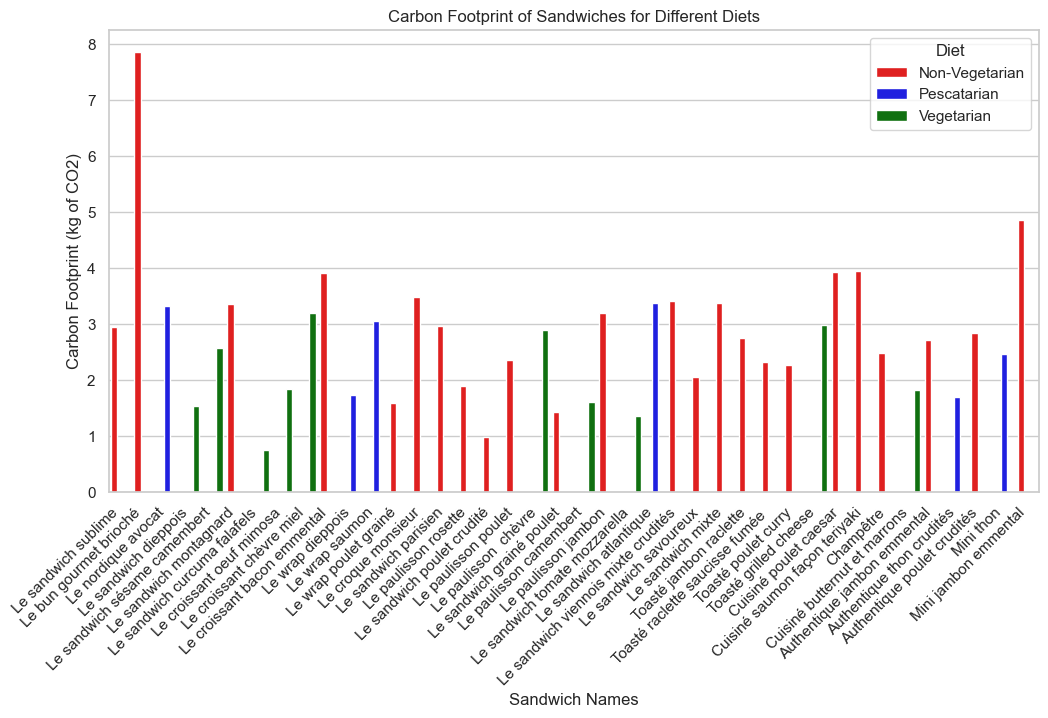

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

custom_palette = {'Vegetarian': 'green', 'Non-Vegetarian': 'red', 'Pescatarian': 'blue'}

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.barplot(x='Name', y='Total_byquan_1kg', hue='Diet', data=combined_df, palette=custom_palette)

plt.xticks(rotation=45, ha='right')

plt.xlabel('Sandwich Names')
plt.ylabel('Carbon Footprint (kg of CO2)')
plt.title('Carbon Footprint of Sandwiches for Different Diets')

plt.legend(title='Diet', loc='upper right')
plt.show()


We notice on this plot that sandwiches that seem to be comprised of ham or beef have a higher carbon footprint than the ones with chicken. Similarily, the ones made out of salmon have a higher carbon footprint that the ones made of tuna. 

We also notice that, generally, non-vegetarian sandwiches seem to have a higher carbon footprint than their vegetarian and pescatarian counterparts. This is in line with our preconceptions as livestock agriculture is a carbon emitting industry. 

Boulangerie
Brioche Dorée    2.851568
Paul             2.668188
Name: Total_byquan_1kg, dtype: float64
Diet
Non-Vegetarian    3.038494
Pescatarian       2.610023
Vegetarian        2.052746
Name: Total_byquan_1kg, dtype: float64


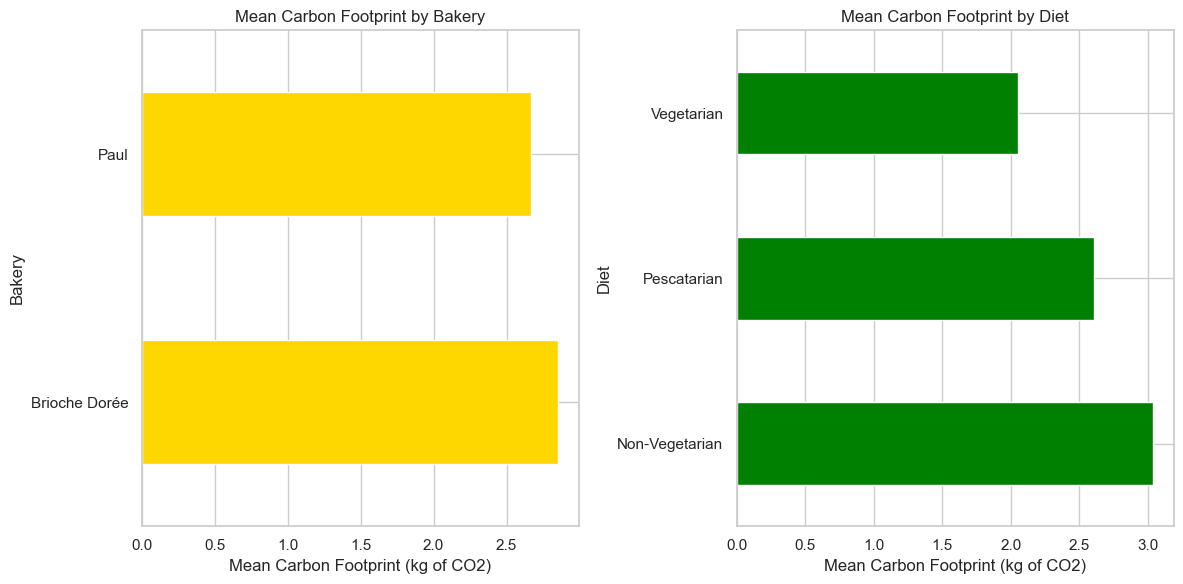

In [43]:
mean_by_bakery = combined_df.groupby('Boulangerie')['Total_byquan_1kg'].mean()
print(mean_by_bakery)
mean_by_diet = combined_df.groupby('Diet')['Total_byquan_1kg'].mean()
print(mean_by_diet)

#relevant plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

#Mean footprint per bakery
mean_by_bakery.plot(kind='barh', ax=ax1, color='gold')
ax1.set_title('Mean Carbon Footprint by Bakery')
ax1.set_xlabel('Mean Carbon Footprint (kg of CO2)')
ax1.set_ylabel('Bakery')

#Mean footprint per diet
mean_by_diet.plot(kind='barh', ax=ax2, color='green')
ax2.set_title('Mean Carbon Footprint by Diet')
ax2.set_xlabel('Mean Carbon Footprint (kg of CO2)')
ax2.set_ylabel('Diet')

plt.tight_layout()
plt.show()


We can see that sandwiches from Paul have, on average, a lower carbon footprint that the sandwiches from Brioche Dorée, 2.89 > 2.66; This represents a difference of 230g of CO2 on average which is arguably negligeable.
Furthermore, as expected, vegetarian sandwiches emit significantly less carbon than non-vegetarian sandwiches on average with difference of about 1kg of CO2 on average, with pescatarian sandwiches somewhere in between. 

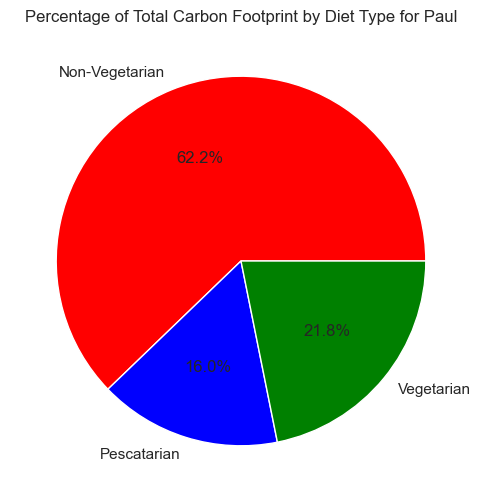

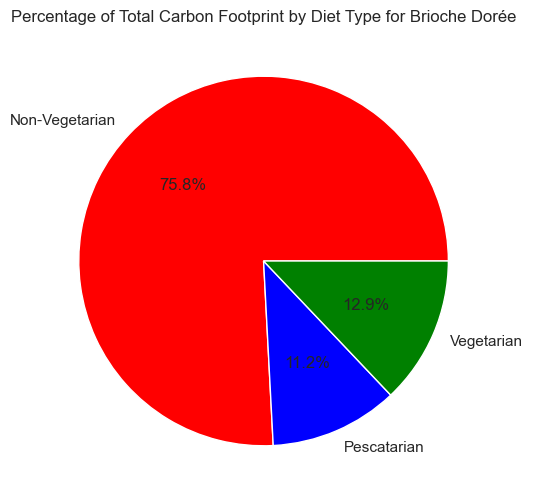

In [44]:
import matplotlib.pyplot as plt

grouped_data = combined_df.groupby(['Boulangerie', 'Diet'])['Total_byquan_1kg'].sum().reset_index()

colors_dict = {'Vegetarian': 'green', 'Non-Vegetarian': 'red', 'Pescatarian': 'blue'}

for bakery in combined_df['Boulangerie'].unique():
    bakery_data = grouped_data[grouped_data['Boulangerie'] == bakery]

    bakery_percentage = bakery_data['Total_byquan_1kg'] / bakery_data['Total_byquan_1kg'].sum() * 100

    plt.figure(figsize=(8, 6))
    plt.pie(bakery_percentage, labels=bakery_data['Diet'], autopct='%1.1f%%', colors=[colors_dict[diet] for diet in bakery_data['Diet']])
    plt.title(f'Percentage of Total Carbon Footprint by Diet Type for {bakery}')
    plt.show()


For both bakeries, non-vegetarian sandwiches represent the bulk of their carbon footprint emissions.

## 7. Flow visualization 

We depicted the most environmentally impactful sandwich, the 'Bun gourmet brioché', using a Mermaid flowchart. We focused on the top 20 flows to maintain clarity and prevent visual clutter.

In [45]:
co2e = final_df.copy()

for category in ['Agriculture_byquan', 'Transformation_byquan', 'Packaging_byquan', 
                 'Transport_byquan', 'Distribution_byquan', 'Consumption_byquan', 'Total_byquan']:
    co2e[f'{category}_1kg'] = co2e[f'{category}'] * 1000 / co2e['Poids_Sandwich']

co2e = co2e.set_index('Nom du Produit en Français')
co2e = co2e[co2e['Sandwich ID'] == '002']

In [46]:
import dataclasses

@dataclasses.dataclass
class Ingredient:
    name: str

    @property
    def short_name(self):
        return self.name.split(',')[0]

    def co2e(self, stage='Total_byquan_1kg'):
        return co2e.loc[self.name][stage] 

@dataclasses.dataclass
class Recipe(Ingredient):
    ingredients: list[Ingredient] = dataclasses.field(default_factory=list)

    def co2e(self, stage='Total_byquan_1kg'):
        return sum(
            ingredient.co2e(stage)
            for ingredient in self.ingredients
        )

In [47]:
bun_gourmet = Recipe('Bun gourmet brioché', 
                     ingredients = [
                          Ingredient('Oignon, cru'),
                          Ingredient('Pomme, pulpe et peau, crue'),
                          Ingredient('Oignon, cuit'),
                          Ingredient('Salade verte, crue, sans assaisonnement'),
                          Ingredient('Boeuf, tende de tranche, rôtie/cuite au four'),
                          Ingredient('Brioche, de boulangerie traditionnelle'),
                          Ingredient('Mousse de foie de porc')
                     ])

In [48]:
def get_flows(item):
    stage_mapping = {
        'Agriculture_byquan_1kg': 'Agriculture',
        'Transformation_byquan_1kg': 'Transformation',
        'Packaging_byquan_1kg': 'Packaging',
        'Transport_byquan_1kg': 'Transport',
        'Distribution_byquan_1kg': 'Distribution',
        'Consumption_byquan_1kg': 'Consumption'
    }

    if isinstance(item, Recipe):
        for ingredient in item.ingredients:
            yield (ingredient.short_name, item.short_name, ingredient.co2e())
            yield from get_flows(ingredient)
    else:
        for stage in stage_mapping:
            yield (stage_mapping[stage], item.short_name, item.co2e(stage))

In [49]:
bun_gourmet_flows = list(get_flows(bun_gourmet))
len(bun_gourmet_flows)

49

In [50]:
import subprocess

flowchart = "flowchart LR"
ranking = sorted(bun_gourmet_flows, key=lambda x: x[2], reverse=True)
for i, (src, dst, co2) in enumerate(ranking[:20]):
    medal = '🥇🥈🥉'[i] if i < 3 else ''
    flowchart += (
        f"\n\t{src.replace(' ', '_')}({src})"
        f'-->|"{medal} {co2:.2f}kgCO2e"|'
        f"{dst.replace(' ', '_')}({dst})"
    )

subprocess.run('pbcopy', text=True, input=flowchart)

CompletedProcess(args='pbcopy', returncode=0)

![png](Flow_Chart.png)

As we can see, the Bun gourmet brioché's carbon footprint can be divised in many different parts. The agricultural effort it took for the bread and meats of the sandwich is by far the most CO2 emitting sector with a total of 7.1kg of CO2 for 1kg of sandwich (reminder: the total carbon footprint of this sandwich is about 7.86kg of CO2). The packing and transformation proceses follow with 0.25 and 0.21 kg of CO2 respectively. 
In reverse order of importance, here are the components of the sandwich that have the highest carbon footprint:

- The agriculture, transformation, packing and transport needed to produce the brioche in the sandwich (1.69 kg of CO2)
- The agriculture needed to produce the beef in the sandwich (5.62 kg of CO2)
- The agriculture, transformation, packing and transport needed to produce the beef in the sandwich (5.77 kg of CO2)

We also notice that the fruit and vegetable that comprise this sandwich, the onion and the apple, have negligeable carbon fottprints of 130g and 20g respectively.

## 8. Skyline: Maximize Energy and Minimize Carbon Footprint

We wish to find which sandwiches dominate other the others with regards to maximizing caloric intake, or energy, and minimizing carbon footprint. For this, we will execute a skyline implementation which iterates over our list of sandwiches and checks if the sandwich is dominated by any other with regards to our criterion (maximizing energy while minimizing carbon footprint).

In [51]:
def a_dominates_b(a, b, to_min, to_max):

    n_better = 0

    for f in to_min:
        if a[f] > b[f]:
            return False
        n_better += a[f] < b[f]

    for f in to_max:
        if a[f] < b[f]:
            return False
        n_better += a[f] > b[f]

    if n_better > 0:
        return True
    return False


def find_skyline_brute_force(df, to_min, to_max):

    rows = df.to_dict(orient='index')
    skyline = set()

    for i in rows:
        dominated = False

        for j in rows:
            if i == j:
                continue

            if a_dominates_b(rows[j], rows[i], to_min, to_max):
                dominated = True
                break

        if not dominated:
            skyline.add(i)

    return df[df.index.isin(skyline)]

to_min = ['Total_byquan']
to_max = ['Énergie (kcal)']

skyline = find_skyline_brute_force(
    combined_df,
    to_min=to_min,
    to_max=to_max
)
skyline

Sandwich ID                           Name  \
6          007   Le sandwich curcuma falafels   
22         023  Le sandwich tomate mozzarella   
25         026          Le sandwich savoureux   
30         031          Toasté grilled cheese   
31         032          Cuisiné poulet caesar   
33         034                      Champêtre   
34         035   Cuisiné butternut et marrons   
38         039                      Mini thon   

                                          Ingredients  Énergie (kcal)  \
6   [pain curcuma sésame noir, falafels, houmous b...          501.98   
22  [pain polka flamand 2 olives, pesto huile, tom...          579.13   
25             [baguette, beurre, rosette, cornichon]          663.20   
30  [pain ciabatta, tome, galettes de pomme de ter...          724.00   
31  [pain au lin, poulet rôti*, sauce parmesan, ca...          689.00   
33  [pain au lin, allumettes de jambon sec, cantal...          603.00   
34  [pain au lin, mélange épeautre butternut et oi...          565.00   
38  [pain bretzel, thon à la ciboulette et zeste d...          261.00   

    Matières grasses (g)  Glucides (g)  Fibres (g)  Protéines (g)  Sel (g)  \
6                  12.14         76.21       10.19          16.87    2.290   
22                 29.77         58.19        4.64          17.29    2.690   
25                 30.77         72.53        3.99          22.05    4.050   
30                 35.80         78.30        5.15          19.50    1.179   
31                 33.30         71.30        6.12          23.00    1.240   
33                 29.80         62.90        4.85          18.40    1.122   
34                 24.50         29.80        1.90          14.40    0.221   
38                  8.55         34.10        2.19          11.00    0.520   

      Boulangerie  Poids_Sandwich  Agriculture_byquan_1kg  \
6            Paul      221.714737                0.215647   
22           Paul      178.492803                0.914784   
25           Paul      252.952576                1.611516   
30  Brioche Dorée      316.542291                1.992796   
31  Brioche Dorée      165.931794                2.380271   
33  Brioche Dorée      153.726565                1.551894   
34  Brioche Dorée      100.135912                0.992918   
38  Brioche Dorée       27.920727                1.779159   

    Transformation_byquan_1kg  Packaging_byquan_1kg  Transport_byquan_1kg  \
6                    0.091337              0.132199              0.247557   
22                   0.187441              0.060959              0.165408   
25                   0.208130              0.036028              0.168620   
30                   0.409499              0.248473              0.232335   
31                   1.018567              0.255971              0.191236   
33                   0.546830              0.126436              0.187084   
34                   0.189330              0.272165              0.203256   
38                   0.193041              0.224651              0.229813   

    Distribution_byquan_1kg  Consumption_byquan_1kg  Total_byquan_1kg  \
6                  0.026902                0.028776          0.742417   
22                 0.015438                0.015682          1.359711   
25                 0.015419                0.010291          2.050005   
30                 0.054571                0.039699          2.977373   
31                 0.026392                0.053141          3.925577   
33                 0.018422                0.059864          2.490530   
34                 0.026736                0.129165          1.813571   
38                 0.014725                0.023611          2.465001   

    Total_byquan            Diet  
6       0.164605      Vegetarian  
22      0.242699      Vegetarian  
25      0.518554  Non-Vegetarian  
30      0.942465      Vegetarian  
31      0.651378  Non-Vegetarian  
33      0.382861  Non-Vegetarian  
34      0.181604      Vegetarian  
38      0.068825  

In [52]:
len(skyline)

8

In [53]:
len(combined_df)

40

Our initial skyline effectively divides by 5 the sandwiches to consider. 

If we wish to maximize caloric intake while minimizing carbon footprint, here are the sandwiches to consider:
- 'Le sandwich curcuma falafels'
- 'Le sandwich tomate mozzarella'
- 'Le sandwich savoureux'
- 'Toasté grilled cheese'
- 'Cuisiné poulet caesar'
- 'Champêtre'
- 'Cuisiné butternut et marrons'
- 'Mini thon'

We notice an abundance of vegetarian sandwiches in the skyline. For the non-vegetarian and pescaterian options, chicken, rosette and tuna appear to be good choices.

Furthermore, for a given sandwich that is part of our skyline, here we consider 'Le sandwich curcuma falafels', here are all the sandwich that are worse than it given our criterion.

In [54]:
all_worse = (
    (combined_df[to_min] > skyline.loc[6, to_min]).all(axis='columns') &
    (combined_df[to_max] < skyline.loc[6, to_max]).all(axis='columns')
)
combined_df[all_worse]

Sandwich ID                         Name  \
7          008     Le croissant oeuf mimosa   
8          009     Le croissant chèvre miel   
9          010  Le croissant bacon emmental   
10         011             Le wrap dieppois   
11         012               Le wrap saumon   
12         013        Le wrap poulet grainé   
13         014           Le croque monsieur   
15         016         Le paulisson rosette   
16         017   Le sandwich poulet crudité   
18         019         Le paulisson  chèvre   
20         021       Le paulisson camembert   
21         022          Le paulisson jambon   
23         024       Le sandwich atlantique   
39         040         Mini jambon emmental   

                                          Ingredients  Énergie (kcal)  \
7        [croissant, œufs mimosa, pousses d'épinards]          413.76   
8   [croissant pur beurre, beurre frais, fromage d...          426.94   
9             [croissant pur beurre, bacon, emmental]          417.28   
10  [galette de blé, thon citronné, salade, tomate...          416.21   
11  [galette de blé, saumon fumé, salade, tomate, ...          425.84   
12  [galette de blé, poulet grainé, salade verte, ...          462.58   
13              [pain de mie, jambon, fromage, crème]          481.89   
15           [petit pain au lait, rosette, cornichon]          329.83   
16  [baguette, poulet, mayonnaise allégée, salade,...          448.25   
18  [petit pain au lait, fromage de chèvre, tartin...          293.35   
20  [petit pain au lait, camembert, salade, moutarde]          309.78   
21  [petit pain au lait, salade verte, tartinade n...          246.93   
23  [baguette graines sésame, tartinade citron, sa...          466.74   
39  [pain bretzel, jambon*, emmental, beurre léger...          308.00   

    Matières grasses (g)  Glucides (g)  Fibres (g)  Protéines (g)  Sel (g)  \
7                  26.06         30.66        1.76          13.26    1.590   
8                  24.96         36.84        2.04          12.71    1.100   
9                  26.18         30.01        1.43          14.70    1.450   
10                 15.54         51.82        2.72          15.91    2.520   
11                 16.38         51.89        2.61          16.42    2.450   
12                 18.28         58.21        3.27          14.67    2.340   
13                 19.70         49.51        5.02          24.13    3.010   
15                 17.43         32.13        1.65          10.28    1.620   
16                 10.80         73.65        4.08          12.08    2.530   
18                 12.68         32.97        1.86          10.90    1.080   
20                 13.54         32.20        2.46          13.56    0.770   
21                  7.93         32.90        1.69          10.15    1.080   
23                 12.95         63.92        4.67          21.30    2.710   
39                 12.20         35.30        1.97          13.40    0.589   

      Boulangerie  Poids_Sandwich  Agriculture_byquan_1kg  \
7            Paul      175.988961                1.088612   
8            Paul       97.158448                2.518898   
9            Paul      102.851115                3.190329   
10           Paul      151.620579                0.767472   
11           Paul      142.216444                1.735019   
12           Paul      143.120588                0.463894   
13           Paul      176.823296                2.707098   
15           Paul      163.068021                1.403005   
16           Paul      215.754798                0.405480   
18           Paul       67.100519                2.213761   
20           Paul      300.841927                0.957464   
21           Paul       59.304987                2.480811   
23           Paul      188.881669                2.429421   
39  Brioche Dorée       57.034664                3.941988   

    Transformation_byquan_1kg  Packaging_byquan_1kg  Transport_byquan_1kg  \
7                    0.246490        

Visually, the skyline looks like this:

In [55]:
import altair as alt

(
    alt.Chart(
        combined_df    
        .assign(is_skyline=lambda df: df.index.isin(skyline.index))
    )
    .mark_point()
    .encode(
        x='Total_byquan:Q',
        y='Énergie (kcal):Q',
        color='is_skyline:N',
        tooltip='Name'
    )
    .interactive()
)

alt.Chart(...)

We now wish to consider people with dietary restrictions or preferences. 

This is what the skyline with the same maximizing and minimizing criterion as before will look like if we only consider vegetarian sandwiches:

In [56]:
combined_v = combined_df[combined_df['Diet']=='Vegetarian']
skyline_v = find_skyline_brute_force(
    combined_v,
    to_min=to_min,
    to_max=to_max
)
skyline_v

Sandwich ID                           Name  \
4          005   Le sandwich sésame camembert   
6          007   Le sandwich curcuma falafels   
22         023  Le sandwich tomate mozzarella   
30         031          Toasté grilled cheese   
34         035   Cuisiné butternut et marrons   

                                          Ingredients  Énergie (kcal)  \
4   [baguette graines sésame, beurre, camembert, s...          668.58   
6   [pain curcuma sésame noir, falafels, houmous b...          501.98   
22  [pain polka flamand 2 olives, pesto huile, tom...          579.13   
30  [pain ciabatta, tome, galettes de pomme de ter...          724.00   
34  [pain au lin, mélange épeautre butternut et oi...          565.00   

    Matières grasses (g)  Glucides (g)  Fibres (g)  Protéines (g)  Sel (g)  \
4                  35.20         61.89        5.52          23.30    1.500   
6                  12.14         76.21       10.19          16.87    2.290   
22                 29.77         58.19        4.64          17.29    2.690   
30                 35.80         78.30        5.15          19.50    1.179   
34                 24.50         29.80        1.90          14.40    0.221   

      Boulangerie  Poids_Sandwich  Agriculture_byquan_1kg  \
4            Paul      314.666170                1.943290   
6            Paul      221.714737                0.215647   
22           Paul      178.492803                0.914784   
30  Brioche Dorée      316.542291                1.992796   
34  Brioche Dorée      100.135912                0.992918   

    Transformation_byquan_1kg  Packaging_byquan_1kg  Transport_byquan_1kg  \
4                    0.108195              0.108874              0.262393   
6                    0.091337              0.132199              0.247557   
22                   0.187441              0.060959              0.165408   
30                   0.409499              0.248473              0.232335   
34                   0.189330              0.272165              0.203256   

    Distribution_byquan_1kg  Consumption_byquan_1kg  Total_byquan_1kg  \
4                  0.038175                0.104086          2.565014   
6                  0.026902                0.028776          0.742417   
22                 0.015438                0.015682          1.359711   
30                 0.054571                0.039699          2.977373   
34                 0.026736                0.129165          1.813571   

    Total_byquan        Diet  
4       0.807123  Vegetarian  
6       0.164605  Vegetarian  
22      0.242699  Vegetarian  
30      0.942465  Vegetarian  
34      0.181604  Vegetarian

For a vegetarian who wishes to maximize caloric intake while minimizing carbon footprint, here are the sandwiches they should consider:
- 'Le sandwich sésame camembert'
- 'Le sandwich curcuma falafels'
- 'Le sandwich tomate mozzarella'
- 'Toasté grilled cheese'
- 'Cuisiné butternut et marrons

Visually, the vegetarian skyline looks like this:

In [57]:
(
    alt.Chart(
        combined_v    
        .assign(is_skyline=lambda df: df.index.isin(skyline_v.index))
    )
    .mark_point()
    .encode(
        x='Total_byquan:Q',
        y='Énergie (kcal):Q',
        color='is_skyline:N',
        tooltip='Name'
    )
    .interactive()
)

alt.Chart(...)

Continuing to consider diferent diet types, this is what the skyline with the same maximizing and minimizing criterion as before will look like if we only consider pescatarian sandwiches:

In [58]:
combined_p = combined_df[combined_df['Diet']=='Pescatarian']
skyline_p = find_skyline_brute_force(
    combined_p,
    to_min=to_min,
    to_max=to_max
)
skyline_p

Sandwich ID                       Name  \
2          003         Le nordique avocat   
10         011           Le wrap dieppois   
36         037  Authentique thon crudités   
38         039                  Mini thon   

                                          Ingredients  Énergie (kcal)  \
2   [pain nordique, saumon fumé, avocat, carotte, ...          565.44   
10  [galette de blé, thon citronné, salade, tomate...          416.21   
36  [pain signature, thon, œuf dur plein air, toma...          553.00   
38  [pain bretzel, thon à la ciboulette et zeste d...          261.00   

    Matières grasses (g)  Glucides (g)  Fibres (g)  Protéines (g)  Sel (g)  \
2                  22.53         63.65        7.55          23.25    2.770   
10                 15.54         51.82        2.72          15.91    2.520   
36                 16.70         74.80        4.71          23.50    0.376   
38                  8.55         34.10        2.19          11.00    0.520   

      Boulangerie  Poids_Sandwich  Agriculture_byquan_1kg  \
2            Paul      187.228760                2.365780   
10           Paul      151.620579                0.767472   
36  Brioche Dorée      233.378680                1.089488   
38  Brioche Dorée       27.920727                1.779159   

    Transformation_byquan_1kg  Packaging_byquan_1kg  Transport_byquan_1kg  \
2                    0.256921              0.226415              0.441760   
10                   0.492923              0.126638              0.257623   
36                   0.242942              0.060970              0.209662   
38                   0.193041              0.224651              0.229813   

    Distribution_byquan_1kg  Consumption_byquan_1kg  Total_byquan_1kg  \
2                  0.013183                0.013610          3.317669   
10                 0.030235                0.064135          1.739026   
36                 0.022633                0.077200          1.702895   
38                 0.014725                0.023611          2.465001   

    Total_byquan         Diet  
2       0.621163  Pescatarian  
10      0.263672  Pescatarian  
36      0.397419  Pescatarian  
38      0.068825  Pescatarian

For a pescatarian who wishes to maximize caloric intake while minimizing carbon footprint, here are the sandwiches they should consider:
- 'Le nordique avocat'
- 'Le wrap dieppois'
- 'Authentique thon crudités'
- 'Mini Thon'

Visually, the pescatarian skyline looks like this:

In [59]:
(
    alt.Chart(
        combined_p   
        .assign(is_skyline=lambda df: df.index.isin(skyline_p.index))
    )
    .mark_point()
    .encode(
        x='Total_byquan:Q',
        y='Énergie (kcal):Q',
        color='is_skyline:N',
        tooltip='Name'
    )
    .interactive()
)

alt.Chart(...)

## 9. Clustering 

Hierarchical clustering is a method of cluster analysis that builds a hierarchy of clusters. In other words, it organizes data points into a tree-like structure where the leaves of the tree represent individual data points, and the root represents a single cluster containing all the data points. This tree-like structure is called a dendrogram. In this part, we will perform hierarchical clustering on our sandwich data and visualize the output using a dendrogram which will provide us with a visual representation of the clustering structure and relationships between data points or clusters.

In [60]:
df_cluster = combined_df[['Name',  'Énergie (kcal)',
       'Matières grasses (g)', 'Glucides (g)', 'Fibres (g)', 'Protéines (g)',
       'Sel (g)', 'Poids_Sandwich', 'Agriculture_byquan_1kg',
       'Transformation_byquan_1kg', 'Packaging_byquan_1kg',
       'Transport_byquan_1kg', 'Distribution_byquan_1kg',
       'Consumption_byquan_1kg', 'Total_byquan_1kg', 'Total_byquan']]
df_cluster = df_cluster.set_index('Name')
df_cluster

Énergie (kcal)  Matières grasses (g)  \
Name                                                                        
Le sandwich sublime                          678.84                 29.87   
Le bun gourmet brioché                       538.73                 29.32   
Le nordique avocat                           565.44                 22.53   
Le sandwich dieppois                         552.31                 17.23   
Le sandwich sésame camembert                 668.58                 35.20   
Le sandwich montagnard                       546.04                 20.18   
Le sandwich curcuma falafels                 501.98                 12.14   
Le croissant oeuf mimosa                     413.76                 26.06   
Le croissant chèvre miel                     426.94                 24.96   
Le croissant bacon emmental                  417.28                 26.18   
Le wrap dieppois                             416.21                 15.54   
Le wrap saumon                               425.84                 16.38   
Le wrap poulet grainé                        462.58                 18.28   
Le croque monsieur                           481.89                 19.70   
Le sandwich parisien                         541.56                 18.91   
Le paulisson rosette                         329.83                 17.43   
Le sandwich poulet crudité                   448.25                 10.80   
Le paulisson poulet                          233.18                  8.18   
Le paulisson  chèvre                         293.35                 12.68   
Le sandwich grainé poulet                    546.85                 22.60   
Le paulisson camembert                       309.78                 13.54   
Le paulisson jambon                          246.93                  7.93   
Le sandwich tomate mozzarella                579.13                 29.77   
Le sandwich atlantique                       466.74                 12.95   
Le sandwich viennois mixte crudités          521.22                 17.03   
Le sandwich savoureux                        663.20                 30.77   
Le sandwich mixte                            615.41                 24.51   
Toasté jambon raclette                       606.00                 23.90   
Toasté raclette saucisse fumée               603.00                 22.00   
Toasté poulet curry                          598.00                 22.60   
Toasté grilled cheese                        724.00                 35.80   
Cuisiné poulet caesar                        689.00                 33.30   
Cuisiné saumon façon teriyaki                611.00                 29.00   
Champêtre                                    603.00                 29.80   
Cuisiné butternut et marrons                 565.00                 24.50   
Authentique jambon emmental                  625.00                 22.00   
Authentique thon crudités                    553.00                 16.70   
Authentique poulet crudités                  534.00                 13.80   
Mini thon                                    261.00                  8.55   
Mini jambon emmental                         308.00                 12.20   

                                     Glucides (g)  Fibres (g)  Protéines (g)  \
Name                                                                           
Le sandwich sublime                         68.93        7.33          29.92   
Le bun gourmet brioché                      47.32        0.75          21.01   
Le nordique avocat                          63.65        7.55          23.25   
Le sandwich dieppois                        74.97        4.08          22.31   
Le sandwich sésame camembert                61.89        5.52          23.30   
Le sandwich montagnard                      64.50        5.36          23.92   
Le sandwich curcuma falafels                76.21       10.19          16.87   
Le croissant oeuf mimosa                    30.66        1.76          13.26   
Le

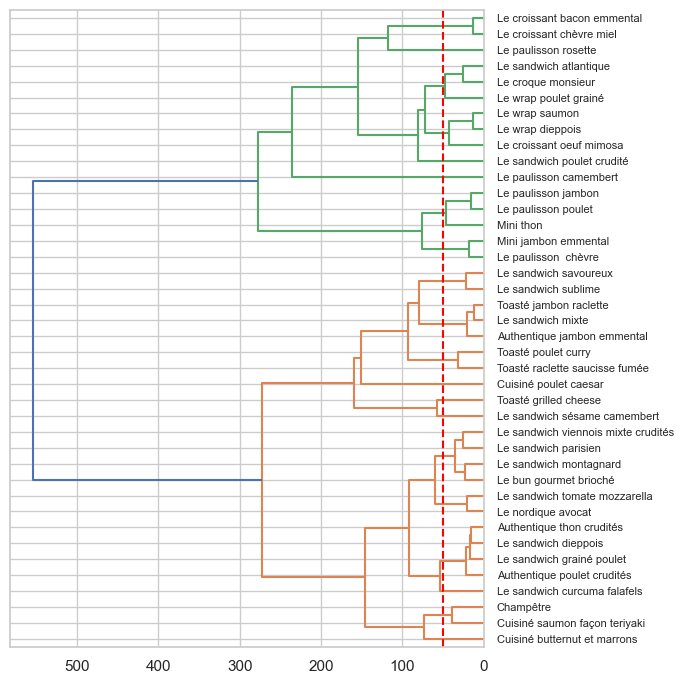

In [61]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

linkage = sch.linkage(df_cluster, 'complete')

fig = plt.figure(figsize=(7, 7))
ax = sch.dendrogram(
    linkage,
    labels=df_cluster.index,
    orientation='left'
)
plt.tight_layout()
plt.axvline(x=50, color='red', linestyle='--')

The dendogram above allows us to visually identify natural groupings or clusters within our sandwich data. Each branch of the dendrogram represents a cluster, and the height at which branches merge indicates the distance or dissimilarity between clusters. By and large, we can identify 2 very distinct clusters from this dendogram, one is represented by green branches and the other is represented by orange branches. 

However, we can identify more grouping if we chose a smaller cut-off.

In [62]:
clusters = sch.fcluster(linkage, t=48, criterion='distance')
clusters

array([11,  6,  5,  3,  7,  6,  4, 15, 18, 18, 15, 15, 16, 16,  6, 19, 17,
       14, 13,  3, 20, 14,  5, 16,  6, 11, 10, 10,  9,  9,  8, 12,  1,  1,
        2, 10,  3,  3, 14, 13], dtype=int32)

In [63]:
sorted(set(clusters))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [64]:
for cluster in sorted(set(clusters)):
    cluster_recipes = df_cluster[clusters == cluster].index.tolist()
    print(cluster_recipes)

['Cuisiné saumon façon teriyaki', 'Champêtre']
['Cuisiné butternut et marrons']
['Le sandwich dieppois', 'Le sandwich grainé poulet', 'Authentique thon crudités', 'Authentique poulet crudités']
['Le sandwich curcuma falafels']
['Le nordique avocat', 'Le sandwich tomate mozzarella']
['Le bun gourmet brioché', 'Le sandwich montagnard', 'Le sandwich parisien', 'Le sandwich viennois mixte crudités']
['Le sandwich sésame camembert']
['Toasté grilled cheese']
['Toasté raclette saucisse fumée ', 'Toasté poulet curry']
['Le sandwich mixte', 'Toasté jambon raclette', 'Authentique jambon emmental']
['Le sandwich sublime', 'Le sandwich savoureux']
['Cuisiné poulet caesar']
['Le paulisson  chèvre', 'Mini jambon emmental']
['Le paulisson poulet', 'Le paulisson jambon', 'Mini thon']
['Le croissant oeuf mimosa', 'Le wrap dieppois', 'Le wrap saumon']
['Le wrap poulet grainé', 'Le croque monsieur', 'Le sandwich atlantique']
['Le sandwich poulet crudité']
['Le croissant chèvre miel', 'Le croissant bacon

In [65]:
sandwich_groups = []

for cluster in sorted(set(clusters)):
    cluster_sandwiches = df_cluster[clusters == cluster].index.tolist()
    sandwich_groups.append(', '.join(cluster_sandwiches))

sandwich_groups_txt = '\n'.join(f'- {rg}' for rg in sandwich_groups)
print(sandwich_groups_txt)

- Cuisiné saumon façon teriyaki, Champêtre
- Cuisiné butternut et marrons
- Le sandwich dieppois, Le sandwich grainé poulet, Authentique thon crudités, Authentique poulet crudités
- Le sandwich curcuma falafels
- Le nordique avocat, Le sandwich tomate mozzarella
- Le bun gourmet brioché, Le sandwich montagnard, Le sandwich parisien, Le sandwich viennois mixte crudités
- Le sandwich sésame camembert
- Toasté grilled cheese
- Toasté raclette saucisse fumée , Toasté poulet curry
- Le sandwich mixte, Toasté jambon raclette, Authentique jambon emmental
- Le sandwich sublime, Le sandwich savoureux
- Cuisiné poulet caesar
- Le paulisson  chèvre, Mini jambon emmental
- Le paulisson poulet, Le paulisson jambon, Mini thon
- Le croissant oeuf mimosa, Le wrap dieppois, Le wrap saumon
- Le wrap poulet grainé, Le croque monsieur, Le sandwich atlantique
- Le sandwich poulet crudité
- Le croissant chèvre miel, Le croissant bacon emmental
- Le paulisson rosette
- Le paulisson camembert


Based on our hierarchical clustering using the complete-linkage method, we can identify 21 natural groupings of our sandwiches:

- Le sandwich sésame camembert
- Toasté grilled cheese
- Le sandwich viennois mixte crudités
- Cuisiné butternut et marrons
- Le bun gourmet brioché, Le nordique avocat, Le sandwich montagnard, Le sandwich parisien, Le sandwich tomate mozzarella
- Le sandwich dieppois, Le sandwich grainé poulet, Authentique thon crudités, Authentique poulet crudités
- Le sandwich curcuma falafels
- Cuisiné saumon façon teriyaki, Champêtre
- Cuisiné poulet caesar
- Le sandwich sublime, Le sandwich savoureux
- Le sandwich mixte, Authentique jambon emmental
- Toasté jambon raclette, Toasté raclette saucisse fumée 
- Toasté poulet curry
- Le paulisson  chèvre, Mini jambon emmental
- Le paulisson poulet, Le paulisson jambon, Mini thon
- Le croissant oeuf mimosa, Le wrap dieppois, Le wrap saumon
- Le wrap poulet grainé, Le croque monsieur, Le sandwich atlantique
- Le sandwich poulet crudité
- Le croissant chèvre miel, Le croissant bacon emmental
- Le paulisson rosette
- Le paulisson camembert

## 10. PCA

This part is independent of the carbon footprint analyzed previously. This part takes into account a new AGRIBALYSE dataset where more indicators are considered than only CO2. In this part, we implemented Principal Component Analysis on different environemental indicators of our sandwiches dataset. 

In [66]:
agribalyse = pd.read_csv("agribalyse-31-synthese.csv")

indicators = {
    'Changement climatique': 'Changement climatique',
    'Appauvrissement de la couche d\'ozone': 'Couche d\'ozone',
    'Rayonnements ionisants': 'Rayonnements',
    'Formation photochimique d\'ozone': 'Formation d\'ozone',
    'Particules fines': 'Particules fines',
    'Effets toxicologiques sur la santé humaine : substances non-cancérogènes': 'Effets non-cancéreux',
    'Effets toxicologiques sur la santé humaine : substances cancérogènes': 'Effets cancéreux',
    'Acidification terrestre et eaux douces': 'Acidification terrestre/eau douce',
    'Eutrophisation eaux douces': 'Eutrophisation eau douce',
    'Eutrophisation marine': 'Eutrophisation marine',
    'Eutrophisation terrestre': 'Eutrophisation terrestre',
    'Écotoxicité pour écosystèmes aquatiques d\'eau douce': 'Écotoxicité eau douce',
    'Utilisation du sol': 'Utilisation sol',
    'Épuisement des ressources eau': 'Épuisement ressources eau',
    'Épuisement des ressources énergétiques': 'Épuisement ressources énergétiques',
    'Épuisement des ressources minéraux': 'Épuisement ressources minéraux'
}

agribalyse.rename(columns=lambda x: 'Effets non-cancéreux' if 'non-cancérogènes' in x else x, inplace=True)
agribalyse.rename(columns=lambda x: 'Effets cancéreux' if 'cancérogènes' in x else x, inplace=True)

agribalyse = agribalyse.rename(columns=indicators)
agribalyse.head()

Code AGB  Code CIQUAL                        Groupe d'aliment  \
0    11084        11084  aides culinaires et ingrédients divers   
1    11023        11023  aides culinaires et ingrédients divers   
2    11000        11000  aides culinaires et ingrédients divers   
3    11093        11093  aides culinaires et ingrédients divers   
4    20995        20995  aides culinaires et ingrédients divers   

  Sous-groupe d'aliment                         Nom du Produit en Français  \
0                algues                                  Agar (algue), cru   
1                herbes                                  Ail séché, poudre   
2                herbes                                           Ail, cru   
3                herbes                                       Aneth, frais   
4                algues  Ao-nori (Enteromorpha sp.), séchée ou déshydratée   

                                            LCI Name  code saison  code avion  \
0                                 Seaweed, agar, raw            2           0   
1                              Garlic, powder, dried            2           0   
2                                      Garlic, fresh            2           0   
3                                        Dill, fresh            2           0   
4  Sea lettuce (Enteromorpha sp.), dried or dehyd...            2           0   

        Livraison Matériau d'emballage         Préparation   DQR  \
0  Ambiant (long)                 LDPE  Pas de préparation  2.99   
1  Ambiant (long)                Verre  Pas de préparation  4.11   
2  Ambiant (long)      Pas d'emballage  Pas de préparation  3.54   
3  Ambiant (long)                 LDPE  Pas de préparation  3.75   
4  Ambiant (long)                 LDPE  Pas de préparation  2.99   

   Score unique EF  Changement climatique  Couche d'ozone  Rayonnements  \
0         1.226025               6.745806    1.017147e-06     11.050022   
1         0.103513               0.750274    1.229332e-07      0.172269   
2         0.064652               0.358043    5.483998e-08      0.143971   
3         0.131581               0.813436    6.268829e-08      0.141342   
4         1.226025               6.745806    1.017147e-06     11.050022   

   Formation d'ozone  Particules fines  Effets non-cancéreux  \
0           0.038875      7.172887e-07          4.771949e-08   
1           0.002936      8.262876e-08          9.281982e-09   
2           0.001081      2.344885e-08          6.066248e-09   
3           0.002559      6.896720e-08          9.739990e-09   
4           0.038875      7.172887e-07          4.771949e-08   

   Effets cancéreux  Acidification terrestre/eau douce  \
0      6.108019e-09                           0.099733   
1      4.343632e-10                           0.006246   
2      2.824785e-10                           0.002036   
3      5.867577e-10                           0.008112   
4      6.108019e-09                           0.099733   

   Eutrophisation eau douce  Eutrophisation marine  Eutrophisation terrestre  \
0                  0.001868               0.013280                  0.127350   
1                  0.000125               0.002379                  0.012785   
2                  0.000069               0.002197                  0.006394   
3                  0.000203               0.004050                  0.031181   
4                  0.001868               0.013280                  0.127350   

   Écotoxicité eau douce  Utilisation sol  Épuisement ressources eau  \
0              43.368466        24.699395                   3.079121   
1               5.672531        20.508995                   2.585763   
2               4.064650        18.871203                   3.104146   
3               5.534832        36.288833                   5.290335   
4              43.368466        24.699395                   3.079121   

   Épuisement ressources énergétiques  Épuisement ressources minéraux  
0                          315.057170                        0.

In [67]:
final_df = final_df[['Sandwich ID', 'Name', 'Boulangerie', 'Ingredients', 'ID', 'ID1', 'ID2', 'Code CIQUAL', 'nom', 'alim_nom_fr', 'Poids_Ingredient']]
final_df

Sandwich ID                                 Name    Boulangerie  \
0           001                  Le Sandwich Sublime           Paul   
1           001                  Le Sandwich Sublime           Paul   
2           001                  Le Sandwich Sublime           Paul   
3           001                  Le Sandwich Sublime           Paul   
4           001                  Le Sandwich Sublime           Paul   
5           002               Le bun gourmet brioché           Paul   
6           002               Le bun gourmet brioché           Paul   
7           002               Le bun gourmet brioché           Paul   
8           002               Le bun gourmet brioché           Paul   
9           002               Le bun gourmet brioché           Paul   
10          002               Le bun gourmet brioché           Paul   
11          002               Le bun gourmet brioché           Paul   
12          003                   Le nordique avocat           Paul   
13          003                   Le nordique avocat           Paul   
14          003                   Le nordique avocat           Paul   
15          003                   Le nordique avocat           Paul   
16          003                   Le nordique avocat           Paul   
17          004                 Le sandwich dieppois           Paul   
18          004                 Le sandwich dieppois           Paul   
19          004                 Le sandwich dieppois           Paul   
20          004                 Le sandwich dieppois           Paul   
21          004                 Le sandwich dieppois           Paul   
22          005         Le sandwich sésame camembert           Paul   
23          005         Le sandwich sésame camembert           Paul   
24          005         Le sandwich sésame camembert           Paul   
25          006               Le sandwich montagnard           Paul   
26          006               Le sandwich montagnard           Paul   
27          006               Le sandwich montagnard           Paul   
28          006               Le sandwich montagnard           Paul   
29          006               Le sandwich montagnard           Paul   
30          007         Le sandwich curcuma falafels           Paul   
31          007         Le sandwich curcuma falafels           Paul   
32          007         Le sandwich curcuma falafels           Paul   
33          007         Le sandwich curcuma falafels           Paul   
34          007         Le sandwich curcuma falafels           Paul   
35          008             Le croissant oeuf mimosa           Paul   
36          008             Le croissant oeuf mimosa           Paul   
37          009             Le croissant chèvre miel           Paul   
38          009             Le croissant chèvre miel           Paul   
39          009             Le croissant chèvre miel           Paul   
40          009             Le croissant chèvre miel           Paul   
41          009             Le croissant chèvre miel           Paul   
42          009             Le croissant chèvre miel           Paul   
43          009             Le croissant chèvre miel           Paul   
44          010          Le croissant bacon emmental           Paul   
45          010          Le croissant bacon emmental           Paul   
46          010          Le croissant bacon emmental           Paul   
47          011                     Le wrap dieppois           Paul   
48          011                     Le wrap dieppois           Paul   
49          011                     Le wrap dieppois           Paul   
50          011                     Le wrap dieppois           Paul   
51          012                       Le wrap saumon           Paul   
52          012                       Le wrap saumon           Paul   
53          012                       Le wrap saumon           Paul   
54          012                       Le wrap saumon           Paul   
55          013             

In [68]:
# Merge the co2 table and sandwich table. 

final_df['ID'] = final_df['ID'].astype(int)
final_df = pd.merge(final_df, agribalyse, on = 'Code CIQUAL')
final_df = final_df.drop_duplicates(subset = ['Name','Code CIQUAL'])
final_df

Sandwich ID                                 Name    Boulangerie  \
0           001                  Le Sandwich Sublime           Paul   
1           020            Le sandwich grainé poulet           Paul   
2           001                  Le Sandwich Sublime           Paul   
3           001                  Le Sandwich Sublime           Paul   
4           001                  Le Sandwich Sublime           Paul   
5           032                CUISINÉ POULET CAESAR  Brioche Dorée   
6           001                  Le Sandwich Sublime           Paul   
7           009             Le croissant chèvre miel           Paul   
8           034                            CHAMPÊTRE  Brioche Dorée   
9           002               Le bun gourmet brioché           Paul   
10          002               Le bun gourmet brioché           Paul   
11          004                 Le sandwich dieppois           Paul   
12          005         Le sandwich sésame camembert           Paul   
13          006               Le sandwich montagnard           Paul   
14          011                     Le wrap dieppois           Paul   
15          012                       Le wrap saumon           Paul   
16          013                Le wrap poulet grainé           Paul   
17          017           Le sandwich poulet crudité           Paul   
18          018                  Le paulisson poulet           Paul   
19          019                 Le paulisson  chèvre           Paul   
20          020            Le sandwich grainé poulet           Paul   
21          021               Le paulisson camembert           Paul   
22          022                  Le paulisson jambon           Paul   
23          023        Le sandwich tomate mozzarella           Paul   
24          024               Le sandwich atlantique           Paul   
25          025  Le sandwich viennois mixte crudités           Paul   
26          032                CUISINÉ POULET CAESAR  Brioche Dorée   
27          033        CUISINÉ SAUMON façon TERIYAKI  Brioche Dorée   
28          037            AUTHENTIQUE THON CRUDITÉS  Brioche Dorée   
29          038          AUTHENTIQUE POULET CRUDITÉS  Brioche Dorée   
30          039                            MINI THON  Brioche Dorée   
31          002               Le bun gourmet brioché           Paul   
32          029      TOASTÉ RACLETTE SAUCISSE FUMÉE   Brioche Dorée   
33          002               Le bun gourmet brioché           Paul   
34          002               Le bun gourmet brioché           Paul   
35          002               Le bun gourmet brioché           Paul   
36          002               Le bun gourmet brioché           Paul   
37          003                   Le nordique avocat           Paul   
38          003                   Le nordique avocat           Paul   
39          012                       Le wrap saumon           Paul   
40          024               Le sandwich atlantique           Paul   
41          033        CUISINÉ SAUMON façon TERIYAKI  Brioche Dorée   
42          003                   Le nordique avocat           Paul   
43          003                   Le nordique avocat           Paul   
44          007         Le sandwich curcuma falafels           Paul   
45          003                   Le nordique avocat           Paul   
46          007         Le sandwich curcuma falafels           Paul   
47          004                 Le sandwich dieppois           Paul   
48          015                 Le sandwich parisien           Paul   
49          017           Le sandwich poulet crudité           Paul   
50          026                Le sandwich savoureux           Paul   
51          027                    Le sandwich mixte           Paul   
52          004                 Le sandwich dieppois           Paul   
53          017           Le sandwich poulet crudité           Paul   
54          018                  Le paulisson poulet           Paul   
55          020            L

In [69]:
# Reorder the columns names to ease the reading
columns_order = ['Sandwich ID', 'Name', 'Boulangerie', 'Ingredients', 'Nom du Produit en Français',  'LCI Name', 'ID','ID1', 'ID2','Code CIQUAL', 'Code AGB'] + \
                 [col for col in final_df.columns if col not in ['Sandwich ID', 'Name', 'Boulangerie', 'Ingredients', 'Nom du Produit en Français', 'LCI Name', 'ID','ID1', 'ID2','Code CIQUAL', 'Code AGB']]
final_df = final_df[columns_order]
final_df = final_df.sort_values(by='Sandwich ID')

print(final_df.shape)
final_df.head()

(205, 39)


Sandwich ID                 Name Boulangerie       Ingredients  \
0         001  Le Sandwich Sublime        Paul  pain multigraine   
2         001  Le Sandwich Sublime        Paul        jambon cru   
3         001  Le Sandwich Sublime        Paul             poire   
4         001  Le Sandwich Sublime        Paul          parmesan   
6         001  Le Sandwich Sublime        Paul   salade Roquette   

                          Nom du Produit en Français  \
0  Pain, baguette ou boule, aux céréales et grain...   
2                                         Jambon cru   
3                                 Poire, pulpe, crue   
4                                           Parmesan   
6                                     Roquette, crue   

                                            LCI Name     ID  ID1  ID2  \
0  Bread, French bread, (baguette or ball), multi...   7255  nan  nan   
2                                     Cured ham, raw  28800  nan  nan   
3                                  Pear, peeled, raw  13107  nan  nan   
4                   Parmesan cheese, from cow's milk  12120  nan  nan   
6                                  Roman rocket, raw  20217  nan  nan   

   Code CIQUAL Code AGB               nom         alim_nom_fr  \
0       7255.0     7255  pain multigraine    pain multigraine   
2      28800.0    28800        jambon cru          Jambon cru   
3      13107.0    13107             poire  Poire, pulpe, crue   
4      12120.0    12120          parmesan            parmesan   
6      20217.0    20217   salade Roquette     salade Roquette   

   Poids_Ingredient                             Groupe d'aliment  \
0        137.274754                          produits céréaliers   
2         23.615951                      viandes, œufs, poissons   
3         26.766531  fruits, légumes, légumineuses et oléagineux   
4         31.755844                    lait et produits laitiers   
6          3.743227  fruits, légumes, légumineuses et oléagineux   

    Sous-groupe d'aliment  code saison  code avion        Livraison  \
0  pains et viennoiseries            2           0  Ambiant (court)   
2            charcuteries            2           0            Glacé   
3                  fruits            2           0  Ambiant (moyen)   
4                fromages            2           0            Glacé   
6                 légumes            2           0  Ambiant (moyen)   

  Matériau d'emballage         Préparation   DQR  Score unique EF  \
0               Papier  Pas de préparation  2.82         0.188895   
2                PP/PE  Pas de préparation  2.51         1.933622   
3      Pas d'emballage  Pas de préparation  2.57         0.087690   
4                 LDPE  Pas de préparation  1.84         0.574785   
6      Pas d'emballage  Pas de préparation  2.60         0.120577   

   Changement climatique  Couche d'ozone  Rayonnements  Formation d'ozone  \
0               1.036317    1.060263e-07      0.487622           0.004266   
2              13.896515    6.187871e-07      5.804589           0.027261   
3               0.364283    7.594182e-08      0.055256           0.001646   
4               6.119573    2.353877e-07      0.667516           0.010784   
6               0.941066    1.182321e-07      0.330043           0.002871   

   Particules fines  Effets non-cancéreux  Effets cancéreux  \
0      1.325086e-07          3.679693e-08      1.938455e-09   
2      1.856253e-06          1.219584e-07      9.613672e-09   
3      2.765509e-08          6.027120e-09      4.429116e-10   
4      4.587828e-07          7.275223e-08      3.232308e-09   
6      6.892573e-08          2.860720e-08      8.316397e-10   

   Acidification terrestre/eau douce  Eutrophisation eau douce  \
0                           0.018983                  0.000426   
2                           0.261989                  0.002182   
3                           0.002742                  0.000048   
4                           0.062920                  0.000839   
6  

As the previous analysis where some ingredients have their "child" ingredient, we processed the same way as before. The difference only resides in the columns to be processed

In [70]:
# Process composed ingredients with more than 1 ID

# Get ingredients with more than 1 ID
composed_ingr = final_df[final_df['ID1'].isin([20106., 13125., 15010., 11061., 20003., 11089., 11054.,
        2028., 15034., 11301., 20116., 20141.])]

composed_ingr['ID2'] = composed_ingr['ID2'].replace(np.nan, 0)

# Change the type of ID1, ID2, Code CIQUAL so that we can merge after
# composed_ingr['ID1'] = composed_ingr['ID1'].astype(float)
# composed_ingr['ID2'] = composed_ingr['ID2'].astype(float)
agribalyse['Code CIQUAL'] = agribalyse['Code CIQUAL'].astype(float)

cols = ['Code CIQUAL','Score unique EF', 'Changement climatique', "Couche d'ozone",
       'Rayonnements', "Formation d'ozone", "Particules fines",
       'Effets non-cancéreux', 'Effets cancéreux',
       'Acidification terrestre/eau douce', 'Eutrophisation eau douce',
       'Eutrophisation marine', 'Eutrophisation terrestre',
       'Écotoxicité eau douce', 'Utilisation sol', 'Épuisement ressources eau',
       'Épuisement ressources énergétiques', 'Épuisement ressources minéraux']

# Merge two df
composed_ingr = pd.merge(composed_ingr, agribalyse[cols], left_on = 'ID1', right_on = 'Code CIQUAL', how = 'left')

# For some ingredients which do not have the corresponding CO2, drop it
# composed_ingr.loc[0, ['Code CIQUAL_y', 'Agriculture_y', 'Transformation_y', 'Packaging_y', 'Transport_y', 'Distribution_y', 'Consumption_y', 'Total_y']] = [20105.0, 0.09, 0, 0, 0.27, 0.05, 0.08, 0.49]
# composed_ingr.loc[19, ['Total_y']] = [0.062]

# Rename the columns with suffix _x and _y to ease the reading
composed_ingr.columns = composed_ingr.columns.str.replace('_x', '')
composed_ingr.columns = composed_ingr.columns.str.replace('_y', '_1')

# Process the same with the ID2
composed_ingr = pd.merge(composed_ingr, agribalyse[cols], left_on = 'ID2', right_on = 'Code CIQUAL', how = 'left')
#composed_ingr.loc[19, ['Code CIQUAL_y', 'Agriculture_y', 'Transformation_y', 'Packaging_y', 'Transport_y', 'Distribution_y', 'Consumption_y', 'Total_y']] = [20034.0, 0.10, 0, 0, 0.25, 0.01, 0.03, 0.39]
composed_ingr.columns = composed_ingr.columns.str.replace('_y', '_2')

print(composed_ingr.shape)
composed_ingr.head()


(18, 75)


Sandwich ID                          Name Boulangerie  \
0         001           Le Sandwich Sublime        Paul   
1         003            Le nordique avocat        Paul   
2         005  Le sandwich sésame camembert        Paul   
3         006        Le sandwich montagnard        Paul   
4         007  Le sandwich curcuma falafels        Paul   

                   Ingredients  \
0        tartinade à la truffe   
1  tartinade citron ciboulette   
2      baguette graines sésame   
3               baguette pavot   
4            houmous betterave   

                          Nom du Produit en Français  \
0  Matière grasse végétale ou margarine, 80% MG, ...   
1  Matière grasse végétale ou margarine, 80% MG, ...   
2             Pain, baguette, de tradition française   
3             Pain, baguette, de tradition française   
4                                            Houmous   

                                            LCI Name     ID      ID1      ID2  \
0  Vegetable fat (margarine type), 80% fat, unsalted  16615  20106.0      0.0   
1  Vegetable fat (margarine type), 80% fat, unsalted  16615  13125.0  11003.0   
2            Bread, French bread, baguette, unsalted   7007  15010.0      0.0   
3            Bread, French bread, baguette, unsalted   7007  11061.0      0.0   
4                                             Hummus  25621  20003.0      0.0   

   Code CIQUAL_x Code AGB                          nom  \
0        16615.0    16615        tartinade à la truffe   
1        16615.0    16615  tartinade citron ciboulette   
2         7007.0     7007      baguette graines sésame   
3         7007.0     7007               baguette pavot   
4        25621.0    25621            houmous betterave   

                   alim_nom_fr  Poids_Ingredient  \
0        tartinade à la truffe         19.126003   
1  tartinade citron ciboulette         11.424619   
2      baguette graines sésame        105.825777   
3               baguette pavot        110.378027   
4            houmous betterave         32.699349   

                         Groupe d'aliment   Sous-groupe d'aliment  \
0                        matières grasses              margarines   
1                        matières grasses              margarines   
2                     produits céréaliers  pains et viennoiseries   
3                     produits céréaliers  pains et viennoiseries   
4  aides culinaires et ingrédients divers                  sauces   

   code saison  code avion        Livraison Matériau d'emballage  \
0            2           0            Glacé                   PP   
1            2           0            Glacé                   PP   
2            2           0  Ambiant (court)               Papier   
3            2           0  Ambiant (court)               Papier   
4            2           0            Glacé                  PVC   

          Préparation   DQR  Score unique EF_x  Changement climatique_x  \
0  Pas de préparation  3.31           0.346228                 2.138335   
1  Pas de préparation  3.31           0.346228                 2.138335   
2  Pas de préparation  1.95           0.100408                 0.686666   
3  Pas de préparation  1.95           0.100408                 0.686666   
4  Pas de préparation  2.95           0.168809                 0.951500   

   Couche d'ozone_x  Rayonnements_x  Formation d'ozone_x  Particules fines_x  \
0      2.226606e-07        0.371655             0.008489        2.107369e-07   
1      2.226606e-07        0.371655             0.008489        2.107369e-07   
2      7.028727e-08        0.485384             0.001998        6.066313e-08   
3      7.028727e-08        0.485384             0.001998        6.066313e-08   
4      1.836278e-07        0.687103             0.004251        7.641942e-08   

   Effets non-cancéreux_x  Effets cancéreux_x  \
0            7.226475e-08        3.848030e-09   
1            7.226475e-08        3.848030e-09   
2            7.812171e-09        8.141289e-10   
3   

In [71]:
# Compute the CO2 for composed ingredients depending on the distribution of "child" ingredients

columns = ['Score unique EF', 'Changement climatique', "Couche d'ozone",
       'Rayonnements', "Formation d'ozone", "Particules fines",
       'Effets non-cancéreux', 'Effets cancéreux',
       'Acidification terrestre/eau douce', 'Eutrophisation eau douce',
       'Eutrophisation marine', 'Eutrophisation terrestre',
       'Écotoxicité eau douce', 'Utilisation sol', 'Épuisement ressources eau',
       'Épuisement ressources énergétiques', 'Épuisement ressources minéraux']
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

df = composed_ingr.copy()

list_1 = ['houmous betterave']

df_1 = df[df['Ingredients'].isin(list_1)]

for category in columns:
    df_1[category] = (df_1[f'{category}_x'] + df_1[f'{category}_1']) / 2

list_2 = ['mayonnaise façon Teriyaki', 'tartinade à la truffe', 'mélange épeautre butternut et oignons rouges']

df_2 = df[df['Ingredients'].isin(list_2)]

for category in columns:
    df_2[category] = df_2[f'{category}_x'] 
    
    
list_3 = ['mélange de carottes chou blanc et céleri']

df_3 = df[df['Ingredients'].isin(list_3)]

for category in columns:
    df_3[category] = (df_3[f'{category}_x'] + df_3[f'{category}_1'] + df_3[f'{category}_2']) / 3
    
list_4 = ['tartinade citron ciboulette', 'tartinade citron aneth']

df_4 = df[df['Ingredients'].isin(list_4)]

for category in columns:
    df_4[category] = 0.8 * df_4[f'{category}_x'] + 0.1 * df_4[f'{category}_1'] + 0.1 * df_4[f'{category}_2']

list_5 = ['pain curcuma sésame noir']

df_5 = df[df['Ingredients'].isin(list_5)]

for category in columns:
    df_5[category] = 0.7 * df_5[f'{category}_x'] + 0.2 * df_5[f'{category}_1'] + 0.1 * df_5[f'{category}_2']
    
list_6 = ['baguette graines sésame', 'baguette pavot',
         'œufs mimosa', 'thon citronné', 'tartinade citron', 'pain au lin']

df_6 = df[df['Ingredients'].isin(list_6)]

for category in columns:
    df_6[category] = 0.8 * df_6[f'{category}_x'] + 0.2 * df_6[f'{category}_1']
        
df_ingred_child = pd.concat([df_1,df_2,df_3,df_4,df_5,df_6])
print(df_ingred_child.shape)
df_ingred_child.head()

(18, 92)


Sandwich ID                           Name    Boulangerie  \
4          007   Le sandwich curcuma falafels           Paul   
0          001            Le Sandwich Sublime           Paul   
12         033  CUISINÉ SAUMON façon TERIYAKI  Brioche Dorée   
17         035   CUISINÉ BUTTERNUT ET MARRONS  Brioche Dorée   
13         033  CUISINÉ SAUMON façon TERIYAKI  Brioche Dorée   

                                     Ingredients  \
4                              houmous betterave   
0                          tartinade à la truffe   
12                     mayonnaise façon Teriyaki   
17  mélange épeautre butternut et oignons rouges   
13      mélange de carottes chou blanc et céleri   

                           Nom du Produit en Français  \
4                                             Houmous   
0   Matière grasse végétale ou margarine, 80% MG, ...   
12                           Mayonnaise (70% MG min.)   
17                 Farine d'épeautre (grand épeautre)   
13          Carottes râpées, avec sauce, préemballées   

                                             LCI Name     ID      ID1  \
4                                              Hummus  25621  20003.0   
0   Vegetable fat (margarine type), 80% fat, unsalted  16615  20106.0   
12                      Mayonnaise (70% fat and more)  11054  11301.0   
17                                        Spelt flour   9480  20141.0   
13                                     Grated carrots  26257  20116.0   

        ID2  Code CIQUAL_x Code AGB  \
4       0.0        25621.0    25621   
0       0.0        16615.0    16615   
12      0.0        11054.0    11054   
17  20324.0         9480.0     9480   
13  20023.0        26257.0    26257   

                                             nom  \
4                              houmous betterave   
0                          tartinade à la truffe   
12                     mayonnaise façon Teriyaki   
17  mélange épeautre butternut et oignons rouges   
13      mélange de carottes chou blanc et céleri   

                                     alim_nom_fr  Poids_Ingredient  \
4                              houmous betterave         32.699349   
0                          tartinade à la truffe         19.126003   
12                     mayonnaise façon Teriyaki         50.893260   
17  mélange épeautre butternut et oignons rouges         11.941916   
13      mélange de carottes chou blanc et céleri          0.986753   

                               Groupe d'aliment     Sous-groupe d'aliment  \
4        aides culinaires et ingrédients divers                    sauces   
0                              matières grasses                margarines   
12       aides culinaires et ingrédients divers                    sauces   
17                          produits céréaliers  farines et pâtes à tarte   
13  fruits, légumes, légumineuses et oléagineux                   légumes   

    code saison  code avion       Livraison Matériau d'emballage  \
4             2           0           Glacé                  PVC   
0             2           0           Glacé                   PP   
12            2           0           Glacé                  PVC   
17            2           0  Ambiant (long)               Papier   
13            2           0           Glacé                   PP   

           Préparation   DQR  Score unique EF_x  Changement climatique_x  \
4   Pas de préparation  2.95           0.168809                 0.951500   
0   Pas de préparation  3.31           0.346228                 2.138335   
12  Pas de préparation  2.49           0.453536                 2.533081   
17  Pas de préparation  3.73           0.153763                 1.152303   
13  Pas de préparation  1.20           0.132167                 0.991515   

    Couche d'ozone_x  Rayonnements_x  Formation d'ozone_x  Particules fines_x  \
4       1.836278e-07        0.687103             0.004251        7.641942e-08   
0       2.226606e-07        0.371655             0.008489      

In [72]:
# Get useful columns from the above dataframe
df_ingred_child = df_ingred_child[['Sandwich ID', 'Name', 'Boulangerie', 'Ingredients',
       'Nom du Produit en Français', 'LCI Name', 'ID', 'ID1', 'ID2',
       'Code CIQUAL_x', 'Code AGB', 'nom', 'alim_nom_fr', 'Poids_Ingredient', 'Score unique EF',
       'Changement climatique', "Couche d'ozone", 'Rayonnements',
       "Formation d'ozone", 'Particules fines', 'Effets non-cancéreux',
       'Effets cancéreux', 'Acidification terrestre/eau douce',
       'Eutrophisation eau douce', 'Eutrophisation marine',
       'Eutrophisation terrestre', 'Écotoxicité eau douce', 'Utilisation sol',
       'Épuisement ressources eau', 'Épuisement ressources énergétiques',
       'Épuisement ressources minéraux']]
df_ingred_child = df_ingred_child.rename(columns={'Code CIQUAL_x': 'Code CIQUAL'})

# Concat with the final_df
final_df = pd.concat([final_df, df_ingred_child])

# Drop duplicates 
final_df.sort_values(by = 'Sandwich ID')
final_df = final_df.drop_duplicates(subset = ['Sandwich ID', 'Name', 'Boulangerie', 'Ingredients',
       'Nom du Produit en Français', 'LCI Name', 'ID'], keep = 'last')
print(final_df.shape)
final_df

(205, 39)


Sandwich ID                                 Name    Boulangerie  \
0           001                  Le Sandwich Sublime           Paul   
2           001                  Le Sandwich Sublime           Paul   
3           001                  Le Sandwich Sublime           Paul   
4           001                  Le Sandwich Sublime           Paul   
6           001                  Le Sandwich Sublime           Paul   
33          002               Le bun gourmet brioché           Paul   
34          002               Le bun gourmet brioché           Paul   
35          002               Le bun gourmet brioché           Paul   
36          002               Le bun gourmet brioché           Paul   
10          002               Le bun gourmet brioché           Paul   
9           002               Le bun gourmet brioché           Paul   
31          002               Le bun gourmet brioché           Paul   
38          003                   Le nordique avocat           Paul   
37          003                   Le nordique avocat           Paul   
42          003                   Le nordique avocat           Paul   
43          003                   Le nordique avocat           Paul   
45          003                   Le nordique avocat           Paul   
62          004                 Le sandwich dieppois           Paul   
58          004                 Le sandwich dieppois           Paul   
47          004                 Le sandwich dieppois           Paul   
52          004                 Le sandwich dieppois           Paul   
11          004                 Le sandwich dieppois           Paul   
110         005         Le sandwich sésame camembert           Paul   
12          005         Le sandwich sésame camembert           Paul   
112         005         Le sandwich sésame camembert           Paul   
118         006               Le sandwich montagnard           Paul   
120         006               Le sandwich montagnard           Paul   
13          006               Le sandwich montagnard           Paul   
65          006               Le sandwich montagnard           Paul   
119         006               Le sandwich montagnard           Paul   
44          007         Le sandwich curcuma falafels           Paul   
121         007         Le sandwich curcuma falafels           Paul   
126         007         Le sandwich curcuma falafels           Paul   
46          007         Le sandwich curcuma falafels           Paul   
125         007         Le sandwich curcuma falafels           Paul   
122         008             Le croissant oeuf mimosa           Paul   
127         008             Le croissant oeuf mimosa           Paul   
129         009             Le croissant chèvre miel           Paul   
128         009             Le croissant chèvre miel           Paul   
113         009             Le croissant chèvre miel           Paul   
131         009             Le croissant chèvre miel           Paul   
133         009             Le croissant chèvre miel           Paul   
134         009             Le croissant chèvre miel           Paul   
7           009             Le croissant chèvre miel           Paul   
130         010          Le croissant bacon emmental           Paul   
135         010          Le croissant bacon emmental           Paul   
141         010          Le croissant bacon emmental           Paul   
14          011                     Le wrap dieppois           Paul   
142         011                     Le wrap dieppois           Paul   
68          011                     Le wrap dieppois           Paul   
148         011                     Le wrap dieppois           Paul   
71          012                       Le wrap saumon           Paul   
144         012                       Le wrap saumon           Paul   
39          012                       Le wrap saumon           Paul   
15          012                       Le wrap saumon           Paul   
149         013             

In [73]:
# Compute the weights for each sandwich

sandwich_weights = final_df.groupby('Sandwich ID')['Poids_Ingredient'].sum().reset_index().rename(columns={'Poids_Ingredient': 'Poids_Sandwich'})

# Merge to the final_df
final_df = pd.merge(final_df, sandwich_weights, on = 'Sandwich ID', how = 'left')
final_df

Sandwich ID                                 Name    Boulangerie  \
0           001                  Le Sandwich Sublime           Paul   
1           001                  Le Sandwich Sublime           Paul   
2           001                  Le Sandwich Sublime           Paul   
3           001                  Le Sandwich Sublime           Paul   
4           001                  Le Sandwich Sublime           Paul   
5           002               Le bun gourmet brioché           Paul   
6           002               Le bun gourmet brioché           Paul   
7           002               Le bun gourmet brioché           Paul   
8           002               Le bun gourmet brioché           Paul   
9           002               Le bun gourmet brioché           Paul   
10          002               Le bun gourmet brioché           Paul   
11          002               Le bun gourmet brioché           Paul   
12          003                   Le nordique avocat           Paul   
13          003                   Le nordique avocat           Paul   
14          003                   Le nordique avocat           Paul   
15          003                   Le nordique avocat           Paul   
16          003                   Le nordique avocat           Paul   
17          004                 Le sandwich dieppois           Paul   
18          004                 Le sandwich dieppois           Paul   
19          004                 Le sandwich dieppois           Paul   
20          004                 Le sandwich dieppois           Paul   
21          004                 Le sandwich dieppois           Paul   
22          005         Le sandwich sésame camembert           Paul   
23          005         Le sandwich sésame camembert           Paul   
24          005         Le sandwich sésame camembert           Paul   
25          006               Le sandwich montagnard           Paul   
26          006               Le sandwich montagnard           Paul   
27          006               Le sandwich montagnard           Paul   
28          006               Le sandwich montagnard           Paul   
29          006               Le sandwich montagnard           Paul   
30          007         Le sandwich curcuma falafels           Paul   
31          007         Le sandwich curcuma falafels           Paul   
32          007         Le sandwich curcuma falafels           Paul   
33          007         Le sandwich curcuma falafels           Paul   
34          007         Le sandwich curcuma falafels           Paul   
35          008             Le croissant oeuf mimosa           Paul   
36          008             Le croissant oeuf mimosa           Paul   
37          009             Le croissant chèvre miel           Paul   
38          009             Le croissant chèvre miel           Paul   
39          009             Le croissant chèvre miel           Paul   
40          009             Le croissant chèvre miel           Paul   
41          009             Le croissant chèvre miel           Paul   
42          009             Le croissant chèvre miel           Paul   
43          009             Le croissant chèvre miel           Paul   
44          010          Le croissant bacon emmental           Paul   
45          010          Le croissant bacon emmental           Paul   
46          010          Le croissant bacon emmental           Paul   
47          011                     Le wrap dieppois           Paul   
48          011                     Le wrap dieppois           Paul   
49          011                     Le wrap dieppois           Paul   
50          011                     Le wrap dieppois           Paul   
51          012                       Le wrap saumon           Paul   
52          012                       Le wrap saumon           Paul   
53          012                       Le wrap saumon           Paul   
54          012                       Le wrap saumon           Paul   
55          013             

In [74]:
# Scale all indicators to 1kg sandwiches 

for category in ['Score unique EF',
       'Changement climatique', "Couche d'ozone", 'Rayonnements',
       "Formation d'ozone", 'Particules fines', 'Effets non-cancéreux',
       'Effets cancéreux', 'Acidification terrestre/eau douce',
       'Eutrophisation eau douce', 'Eutrophisation marine',
       'Eutrophisation terrestre', 'Écotoxicité eau douce', 'Utilisation sol',
       'Épuisement ressources eau', 'Épuisement ressources énergétiques',
       'Épuisement ressources minéraux']:
    final_df[f'{category}'] = final_df[f'{category}'] * 1000 / final_df['Poids_Sandwich']
    
final_df

Sandwich ID                                 Name    Boulangerie  \
0           001                  Le Sandwich Sublime           Paul   
1           001                  Le Sandwich Sublime           Paul   
2           001                  Le Sandwich Sublime           Paul   
3           001                  Le Sandwich Sublime           Paul   
4           001                  Le Sandwich Sublime           Paul   
5           002               Le bun gourmet brioché           Paul   
6           002               Le bun gourmet brioché           Paul   
7           002               Le bun gourmet brioché           Paul   
8           002               Le bun gourmet brioché           Paul   
9           002               Le bun gourmet brioché           Paul   
10          002               Le bun gourmet brioché           Paul   
11          002               Le bun gourmet brioché           Paul   
12          003                   Le nordique avocat           Paul   
13          003                   Le nordique avocat           Paul   
14          003                   Le nordique avocat           Paul   
15          003                   Le nordique avocat           Paul   
16          003                   Le nordique avocat           Paul   
17          004                 Le sandwich dieppois           Paul   
18          004                 Le sandwich dieppois           Paul   
19          004                 Le sandwich dieppois           Paul   
20          004                 Le sandwich dieppois           Paul   
21          004                 Le sandwich dieppois           Paul   
22          005         Le sandwich sésame camembert           Paul   
23          005         Le sandwich sésame camembert           Paul   
24          005         Le sandwich sésame camembert           Paul   
25          006               Le sandwich montagnard           Paul   
26          006               Le sandwich montagnard           Paul   
27          006               Le sandwich montagnard           Paul   
28          006               Le sandwich montagnard           Paul   
29          006               Le sandwich montagnard           Paul   
30          007         Le sandwich curcuma falafels           Paul   
31          007         Le sandwich curcuma falafels           Paul   
32          007         Le sandwich curcuma falafels           Paul   
33          007         Le sandwich curcuma falafels           Paul   
34          007         Le sandwich curcuma falafels           Paul   
35          008             Le croissant oeuf mimosa           Paul   
36          008             Le croissant oeuf mimosa           Paul   
37          009             Le croissant chèvre miel           Paul   
38          009             Le croissant chèvre miel           Paul   
39          009             Le croissant chèvre miel           Paul   
40          009             Le croissant chèvre miel           Paul   
41          009             Le croissant chèvre miel           Paul   
42          009             Le croissant chèvre miel           Paul   
43          009             Le croissant chèvre miel           Paul   
44          010          Le croissant bacon emmental           Paul   
45          010          Le croissant bacon emmental           Paul   
46          010          Le croissant bacon emmental           Paul   
47          011                     Le wrap dieppois           Paul   
48          011                     Le wrap dieppois           Paul   
49          011                     Le wrap dieppois           Paul   
50          011                     Le wrap dieppois           Paul   
51          012                       Le wrap saumon           Paul   
52          012                       Le wrap saumon           Paul   
53          012                       Le wrap saumon           Paul   
54          012                       Le wrap saumon           Paul   
55          013             

In [75]:
final_df = final_df[['Name', 'Score unique EF', 'Changement climatique',
       "Couche d'ozone", 'Rayonnements', "Formation d'ozone",
       'Particules fines', 'Effets non-cancéreux',
       'Effets cancéreux', 'Acidification terrestre/eau douce',
       'Eutrophisation eau douce', 'Eutrophisation marine',
       'Eutrophisation terrestre', 'Écotoxicité eau douce',
       'Utilisation sol', 'Épuisement ressources eau',
       'Épuisement ressources énergétiques',
       'Épuisement ressources minéraux']]

final_df = final_df.groupby('Name').sum().reset_index()
final_df

Name  Score unique EF  \
0           AUTHENTIQUE JAMBON EMMENTAL        10.899287   
1           AUTHENTIQUE POULET CRUDITÉS        11.411969   
2             AUTHENTIQUE THON CRUDITÉS         7.609026   
3                             CHAMPÊTRE        25.640307   
4          CUISINÉ BUTTERNUT ET MARRONS        14.980668   
5                 CUISINÉ POULET CAESAR        23.217661   
6         CUISINÉ SAUMON façon TERIYAKI        13.751428   
7                   Le Sandwich Sublime        13.421519   
8                Le bun gourmet brioché        29.337920   
9           Le croissant bacon emmental        17.655514   
10             Le croissant chèvre miel        32.769300   
11             Le croissant oeuf mimosa         4.696371   
12                   Le croque monsieur        11.165225   
13                   Le nordique avocat        10.463551   
14                 Le paulisson  chèvre        40.781509   
15               Le paulisson camembert         4.000742   
16                  Le paulisson jambon        29.058191   
17                  Le paulisson poulet        17.958118   
18                 Le paulisson rosette         7.286551   
19               Le sandwich atlantique         9.646374   
20         Le sandwich curcuma falafels         4.283265   
21                 Le sandwich dieppois         5.359733   
22            Le sandwich grainé poulet         6.026444   
23                    Le sandwich mixte        11.249632   
24               Le sandwich montagnard        23.292855   
25                 Le sandwich parisien         9.646684   
26           Le sandwich poulet crudité         4.452333   
27                Le sandwich savoureux         6.860037   
28         Le sandwich sésame camembert         5.162017   
29        Le sandwich tomate mozzarella         6.547042   
30  Le sandwich viennois mixte crudités        12.813221   
31                     Le wrap dieppois         5.810781   
32                Le wrap poulet grainé         7.875528   
33                       Le wrap saumon        12.642200   
34                 MINI JAMBON EMMENTAL        44.995928   
35                            MINI THON        46.252596   
36                TOASTÉ GRILLED CHEESE         8.211072   
37               TOASTÉ JAMBON RACLETTE        10.528331   
38                  TOASTÉ POULET CURRY         4.979935   
39      TOASTÉ RACLETTE SAUCISSE FUMÉE          9.806921   

    Changement climatique  Couche d'ozone  Rayonnements  Formation d'ozone  \
0               96.991551        0.000011     22.396441           0.185950   
1               79.543031        0.000006     19.710902           0.225665   
2               48.074849        0.000006     15.567178           0.266381   
3              176.054831        0.000015     59.122869           0.415892   
4              100.793887        0.000011     33.391460           0.327789   
5              167.341774        0.000011    106.738208           0.401912   
6               99.633657        0.000011     29.962098           0.401306   
7              101.105559        0.000006     31.849956           0.228318   
8              276.895469        0.000011     34.622786           0.476675   
9              152.850980        0.000006     34.441113           0.295280   
10             239.549783        0.000016     35.707105           0.590903   
11              30.799410        0.000002      9.861346           0.088391   
12              97.408007        0.000012     23.453395           0.189691   
13              72.352998        0.000008     18.077931           0.296861   
14             234.436034        0.000031     51.174452           0.747941   
15              34.784883        0.000002      7.161544           0.083088   
16             211.336862        0.000037     65.454398           0.529052   
17             131.839254        0.000012     34.728599           0.385035   
18              54.785252        0.000003     20.857011           0.116646   
19            

In [76]:
final_df = final_df.set_index('Name')
final_df

Score unique EF  Changement climatique  \
Name                                                                          
AUTHENTIQUE JAMBON EMMENTAL                10.899287              96.991551   
AUTHENTIQUE POULET CRUDITÉS                11.411969              79.543031   
AUTHENTIQUE THON CRUDITÉS                   7.609026              48.074849   
CHAMPÊTRE                                  25.640307             176.054831   
CUISINÉ BUTTERNUT ET MARRONS               14.980668             100.793887   
CUISINÉ POULET CAESAR                      23.217661             167.341774   
CUISINÉ SAUMON façon TERIYAKI              13.751428              99.633657   
Le Sandwich Sublime                        13.421519             101.105559   
Le bun gourmet brioché                     29.337920             276.895469   
Le croissant bacon emmental                17.655514             152.850980   
Le croissant chèvre miel                   32.769300             239.549783   
Le croissant oeuf mimosa                    4.696371              30.799410   
Le croque monsieur                         11.165225              97.408007   
Le nordique avocat                         10.463551              72.352998   
Le paulisson  chèvre                       40.781509             234.436034   
Le paulisson camembert                      4.000742              34.784883   
Le paulisson jambon                        29.058191             211.336862   
Le paulisson poulet                        17.958118             131.839254   
Le paulisson rosette                        7.286551              54.785252   
Le sandwich atlantique                      9.646374              68.746917   
Le sandwich curcuma falafels                4.283265              27.996010   
Le sandwich dieppois                        5.359733              34.661731   
Le sandwich grainé poulet                   6.026444              38.810547   
Le sandwich mixte                          11.249632             101.817161   
Le sandwich montagnard                     23.292855             173.614130   
Le sandwich parisien                        9.646684              82.396066   
Le sandwich poulet crudité                  4.452333              30.523617   
Le sandwich savoureux                       6.860037              58.843531   
Le sandwich sésame camembert                5.162017              49.252129   
Le sandwich tomate mozzarella               6.547042              52.423667   
Le sandwich viennois mixte crudités        12.813221             104.104805   
Le wrap dieppois                            5.810781              38.949251   
Le wrap poulet grainé                       7.875528              51.606649   
Le wrap saumon                             12.642200              90.557471   
MINI JAMBON EMMENTAL                       44.995928             409.811316   
MINI THON                                  46.252596             316.432899   
TOASTÉ GRILLED CHEESE                       8.211072              52.465070   
TOASTÉ JAMBON RACLETTE                     10.528331              93.398692   
TOASTÉ POULET CURRY                         4.979935              37.298600   
TOASTÉ RACLETTE SAUCISSE FUMÉE              9.806921              80.881179   

                                     Couche d'ozone  Rayonnements  \
Name                                                                
AUTHENTIQUE JAMBON EMMENTAL                0.000011     22.396441   
AUTHENTIQUE POULET CRUDITÉS                0.000006     19.710902   
AUTHENTIQUE THON CRUDITÉS                  0.000006     15.567178   
CHAMPÊTRE                                  0.000015     59.122869   
CUISINÉ BUTTERNUT ET MARRONS               0.000011     33.391460   
CUISINÉ POULET CAESAR                      0.000011    106.738208   
CUISINÉ SAUMON façon TERIYAKI              0.000011     29.962098   
Le Sandwich Sublime                        0.000006     31.849956   
Le bun gourmet brioché      

Initially, we calculated the correlation between variables and visually represented it using a heatmap. The observation reveals substantial correlations among many indicators, with the lowest correlation being 0.4. This high correlation suggests that employing Principal Component Analysis (PCA) might yield favorable results, as only one or two components could potentially capture the majority of the information in the dataset.

In [77]:
import altair as alt

corr = (
    final_df
    .corr()
    .stack()
    .to_frame()
    .reset_index()
)
corr.columns = ['x', 'y', 'corr']

# Create a heatmap of the correlation matrix
heatmap = alt.Chart(corr).mark_rect().encode(
    x=alt.X('x:O', title=None),
    y=alt.Y('y:O', title=None),
    color=alt.Color('corr:Q', scale=alt.Scale(scheme='blueorange'))
)

# Create text labels for the correlation values
text = alt.Chart(corr).mark_text(baseline='middle').encode(
    x=alt.X('x:O'),
    y=alt.Y('y:O'),
    text=alt.Text('corr:Q', format='.1f'),
)

# Combine the heatmap and text labels
heatmap + text

alt.LayerChart(...)

Observing the plot, it becomes evident that the majority of variables have a substantial impact on the first principal component rather than the second one. This suggests that the first principal component captures a significant portion of the overall variability in the dataset

In [78]:
import prince

pca = prince.PCA(n_components=2)
pca = pca.fit(final_df)
pca.plot(final_df, x_component=0, y_component=1)

alt.LayerChart(...)

As anticipated, the first principal component encompasses 86.84% of the variance, signifying that it captures the majority of information present in the dataset. This high percentage underscores the effectiveness of the first component in summarizing and representing the underlying patterns in the data.

In [79]:
pca.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0             14.762        86.84%                     86.84%
1              0.663         3.90%                     90.74%

Nearly all variables make significant contributions to the first principal component. In contrast, the second component appears to contribute relatively little information. 

In [80]:
(
    pca.column_cosine_similarities_
    .style
    .applymap(lambda x: 'background-color: yellow' if x > 0.5 else '')
)

Examining the prototypes allows us to identify which sandwiches are correlated with each principal component.

However, considering the fact that the majority of variables have significant contributions to the first principal component and there is no discernible pattern between the two components, distinguishing sandwiches based on environmental indicators might not be straightforward. However, by retaining only one principal component, we achieve dimensionality reduction while preserving the most variance in the data. This reduction can be advantageous for subsequent analyses, facilitating simplicity and interpretability while still capturing the essential information encapsulated in the dataset.

In [81]:
pca.row_cosine_similarities(final_df).sort_values(0).tail(8)


component                             0             1
Name                                                 
Le sandwich sésame camembert   0.970767  4.994607e-07
Le sandwich tomate mozzarella  0.973180  1.179410e-02
Le sandwich savoureux          0.973871  6.772511e-03
Le sandwich curcuma falafels   0.985883  8.277890e-03
Le paulisson camembert         0.986913  6.743394e-04
Le croissant oeuf mimosa       0.987317  6.842297e-05
Le sandwich poulet crudité     0.987714  3.565094e-03
TOASTÉ POULET CURRY            0.994571  7.027686e-06

In [82]:
pca.row_cosine_similarities(final_df).sort_values(1).tail(8)


component                                   0         1
Name                                                   
AUTHENTIQUE JAMBON EMMENTAL          0.789022  0.130290
Le croissant chèvre miel             0.717307  0.136364
Le sandwich mixte                    0.746211  0.145719
Le croque monsieur                   0.736766  0.148490
Le sandwich viennois mixte crudités  0.434176  0.214776
Le nordique avocat                   0.375582  0.344533
CUISINÉ BUTTERNUT ET MARRONS         0.153961  0.394869
Le croissant bacon emmental          0.163682  0.395355

## 11. Conclusion

Given that the sandwich is the most often consumed restauration product in France, our goal was to evaluate the carbon footprint of the sandwich menus of some of the biggest bakeries in the country: Paul and Brioche Dorée. 

Through thorough data mining, we have found that sandwiches such as 'Le bun gourmet brioché' or the common 'jambon emmental' have a large carbon footprint and thus should probably be avoided by environmentally conscious consumers. On the other hand, sandwiches such as Paul's 'Le sandwich curcuma falafels' or 'Le sandwich poulet crudité' have a relatively low carbon footprint. 

Generally speaking, our findings advocate for the preference of vegetarian sandwiches, which emit, on average, less CO2 compared to their non-vegetarian counterparts (2.05kg vs. 3.05kg). Pescatarian options, with an average emission of 2.61kg of CO2 per 1kg of sandwich, present a balanced choice for environmentally conscious consumers. 

Furthermore, our assessment highlighted a notable difference between Paul and Brioche Dorée, with Paul exhibiting a lower average carbon footprint per sandwich (2.66kg vs. 2.89kg). Consequently, we recommend environmentally conscious consumers opt for vegetarian sandwiches from Paul. We also found that 62% and 76% of carbon footprints are done by non-vegetarian sandwiches for Paul ad Brioche Dorée, respectively. This leads us to believe that both bakeries perhaps need to limit their non-vegetarian options.

Our detailed examination included a flow chart illustrating the contributing factors to the carbon footprint of the most emissions-intensive sandwich, the 'Bun gourmet brioché.' Agriculture, particularly in beef production, emerged as the predominant source of CO2 emissions, while while the fruit and vegetables in this sandwich have a small, almost negligeable carbon footprint. This underscores the need for bakeries to source ingredients sustainably, prioritizing suppliers with environmentally friendly agricultural practices.

The creation of a skyline, balancing energy/caloric intake against carbon footprint, identified several optimal choices. Vegetarian sandwiches like 'Le sandwich curcuma falafels' and 'Le sandwich tomate mozzarella' stood out. For non-vegetarians and pescatarians, options featuring chicken, rosette, or tuna proved to be favorable. Limiting our skyline to consider only individuals with specific diet restrictions or preferences, we can recommend the sandwiches 'Le nordique avocat', 'Le wrap dieppois', 'Authentique thon crudités' and 'Mini Thon' to pescatarians and 'Le sandwich sésame camembert', 'Le sandwich curcuma falafels', 'Le sandwich tomate mozzarella', 'Toasté grilled cheese' and 'Cuisiné butternut et marrons' to vegetarians. 

Additionally, we did a cluster analysis on our sandwich menu data and built a dendogram that uses hierarchical clustering to find a natural grouping of sandwiches. Therefore, we can offer a practical approach for consumers to choose sandwiches within the same group, ensuring a lower carbon footprint while adhering to their dietary preferences.

Finally, we conducted a Principal Component Analysis (PCA) on the environmental indicators of our sandwich menu data. The analysis reveals that most indicators are highly correlated, and we can account for 86.84% of the data's variance using only one dimension. With the inclusion of one additional dimension, the cumulative variance increases to over 90%, but almost all variables contribute significantly to the first dimension and minimally to the second dimension. The correlation of observations with the first dimension reaches 99%, while the highest correlation with the second dimension is less than 40%. All these PCA results indicate that we can efficiently explain the data by projecting it onto only one dimension, compared to using all the original dimensions.

In conclusion, our extensive data mining project provides valuable insights into the environmental impact of the most consumed restauration product in France. While we offer recommendations for environmentally conscious consumers, the primary responsibility for reducing our collective carbon footprint rests with bakeries and establishments. They must source ingredients from low-carbon industries and offer products with a smaller environmental impact, contributing to a more sustainable future.


# References

HALFORD Max, Measuring the carbon footprint of pizzas, https://maxhalford.github.io/blog/carbon-footprint-pizzas/